In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

print("alpha",alpha)
print(datetime.datetime.now())

alpha 0.1
2023-06-01 23:33:50.009243


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 48
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-10.9579)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(6.7339)
penalty_target_min tensor(-12.3239) penalty_target_max tensor(7.7515)
train_loss:  -10.954536772155762
valid_loss:  -10.36820057373047
h_min_tilde -12.323891 ell_tilde -10.837269532470705 kappa_tilde 0.0008201623821220675


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.289984941482544

 2 3.1755802631378174

 3 3.3888585567474365

 4 3.3946373462677

 5 3.1514365673065186

 6 3.118030309677124

 7 3.2544705867767334

 8 3.2626922130584717

 9 3.270219564437866

 10 3.2408316135406494

 11 3.3335328102111816

 12 3.1873772144317627

 13 3.2291345596313477

 14 3.3768837451934814

 15 3.394864082336426

 16 3.4261133670806885

 17 3.258878469467163

 18 3.254361629486084

 19 3.2805590629577637

 20 3.231903076171875

 21 3.183882236480713

 22 3.173417806625366

 23 3.2498011589050293

 24 3.2755589485168457

 25 3.195591926574707

 26 3.255544424057007

 27 3.2866244316101074

 28 3.2239675521850586

 29 3.2554571628570557

 30 3.2994391918182373

 31 3.231658697128296

 32 3.186511754989624

 33 3.2642123699188232

 34 3.2015786170959473

 35 3.216573476791382

 36 3.3071112632751465

 37 3.2489726543426514

 38 3.252011299133301

 39 3.2777767181396484

 40 3.264111042022705

 41 3.214038848876953

 42 3.2852983474731445

 43 3.34570169448852

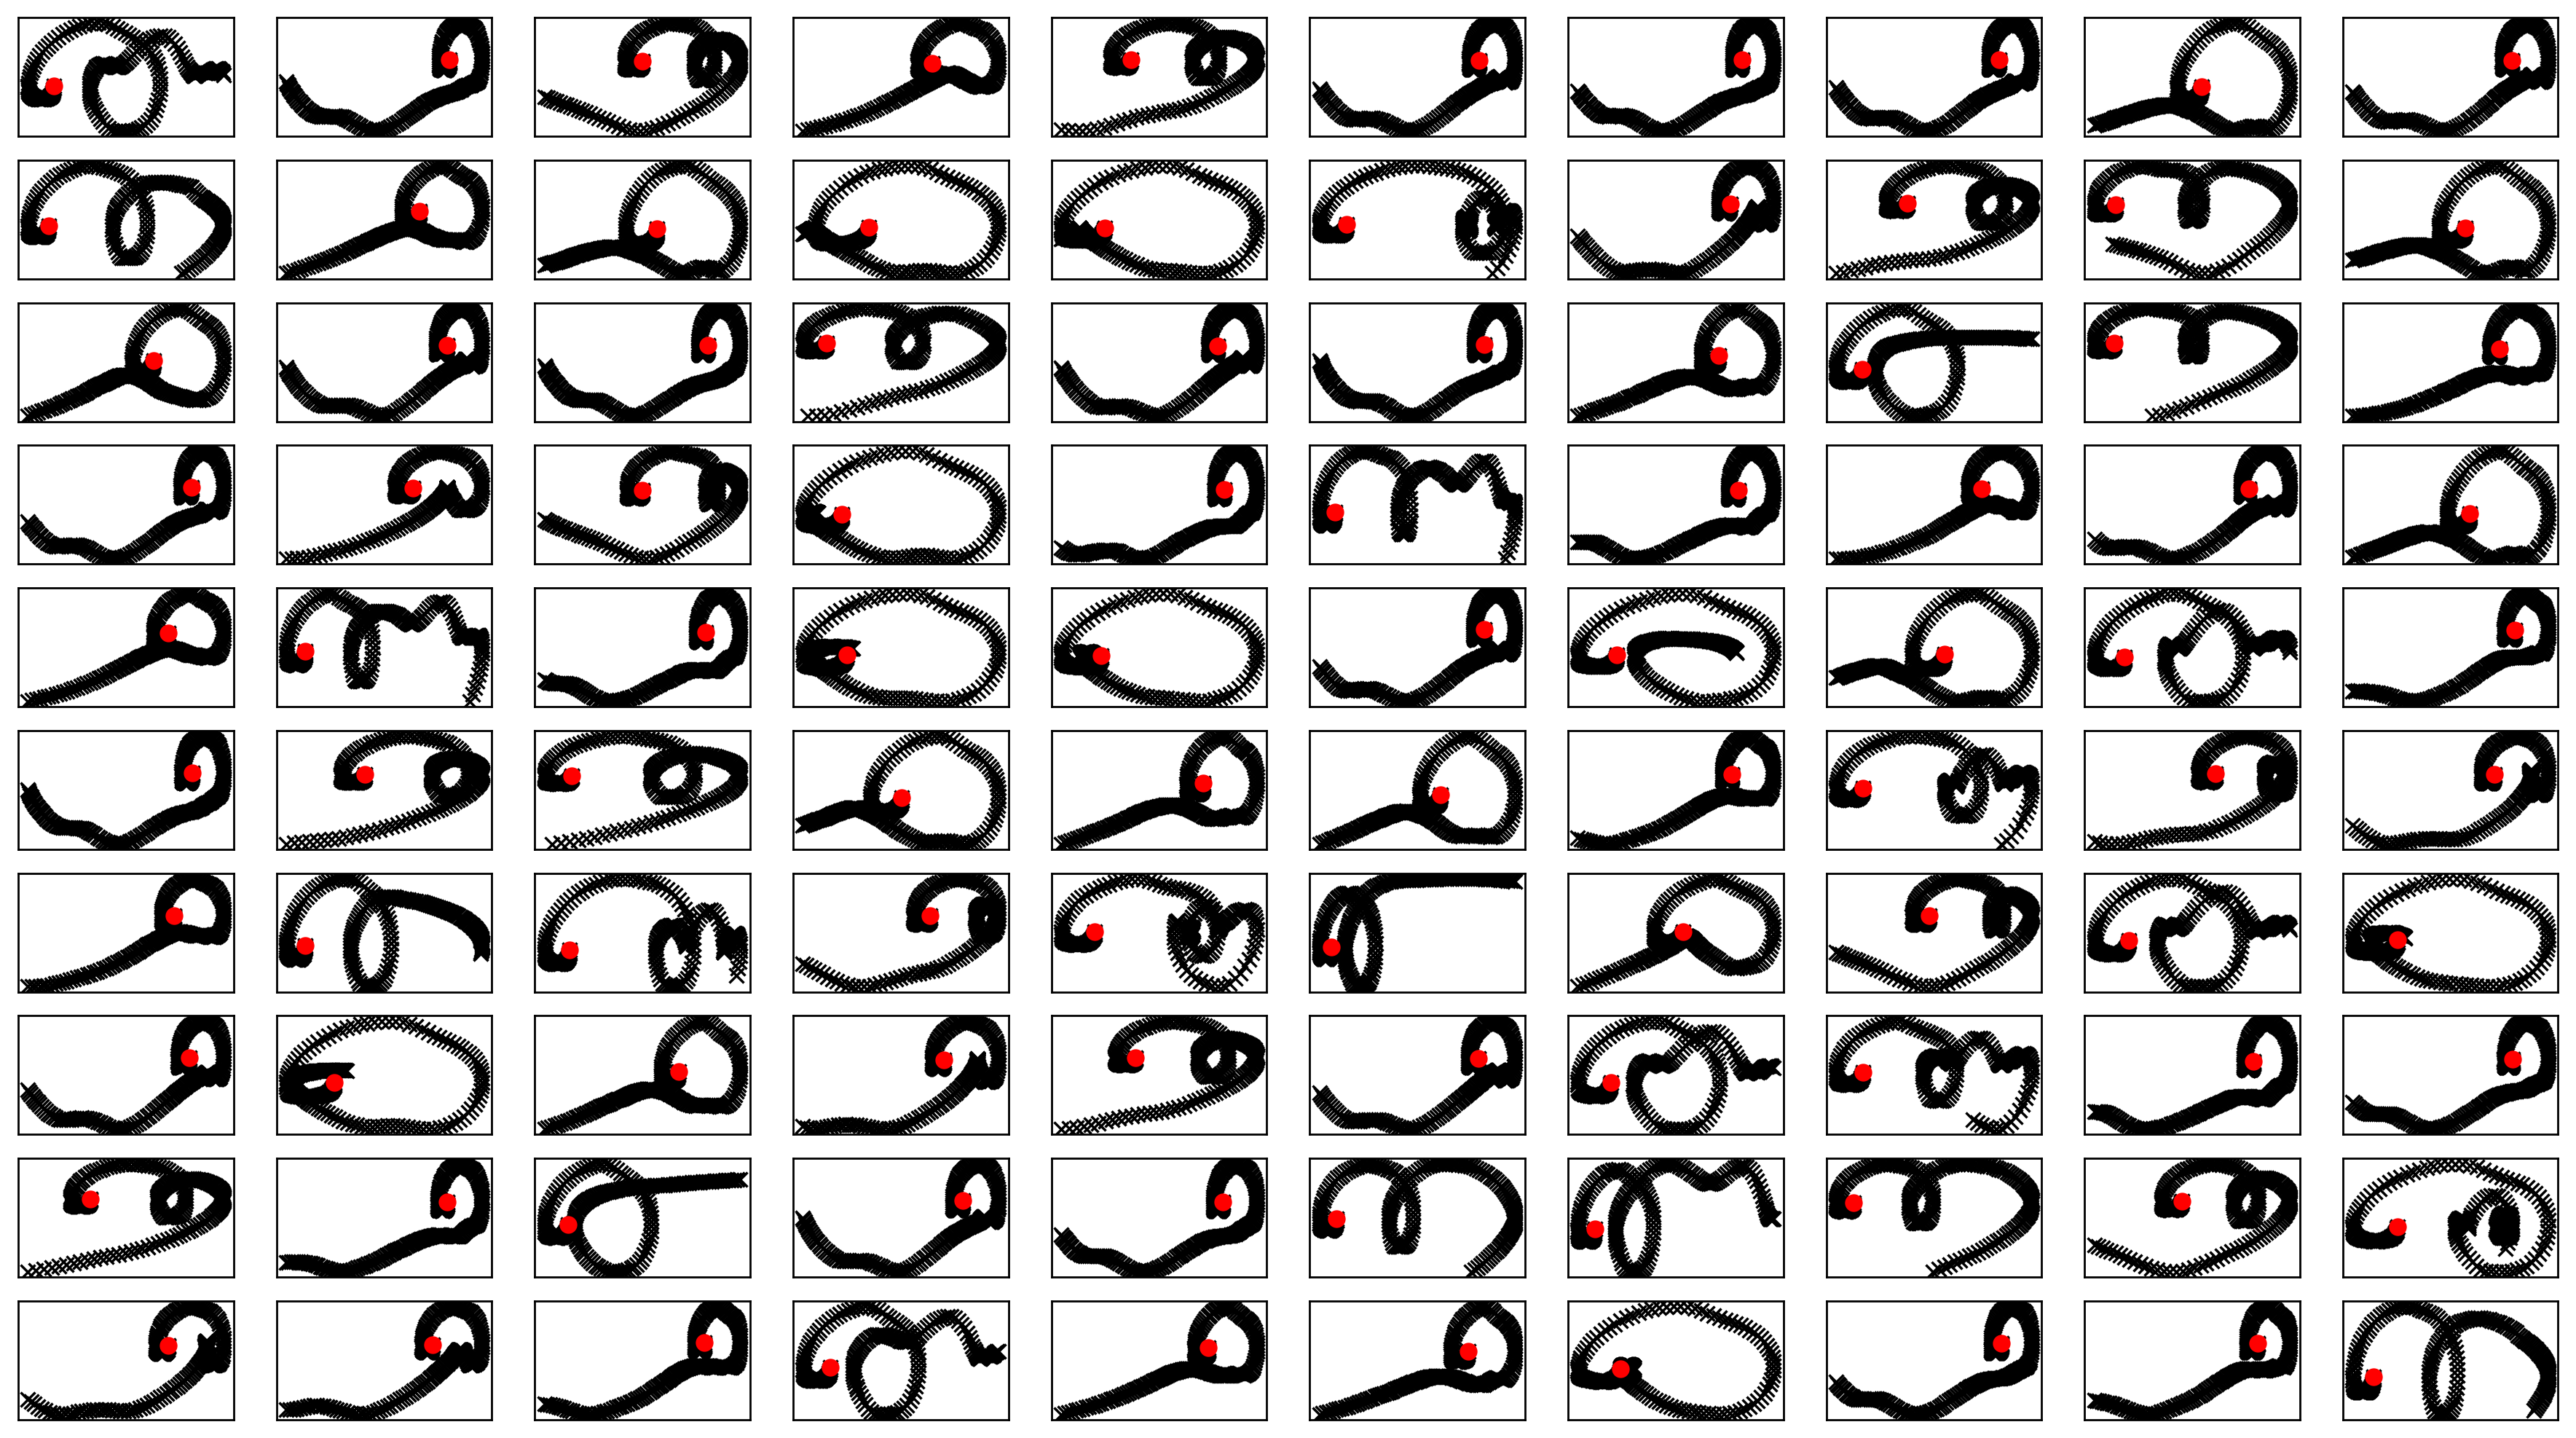

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

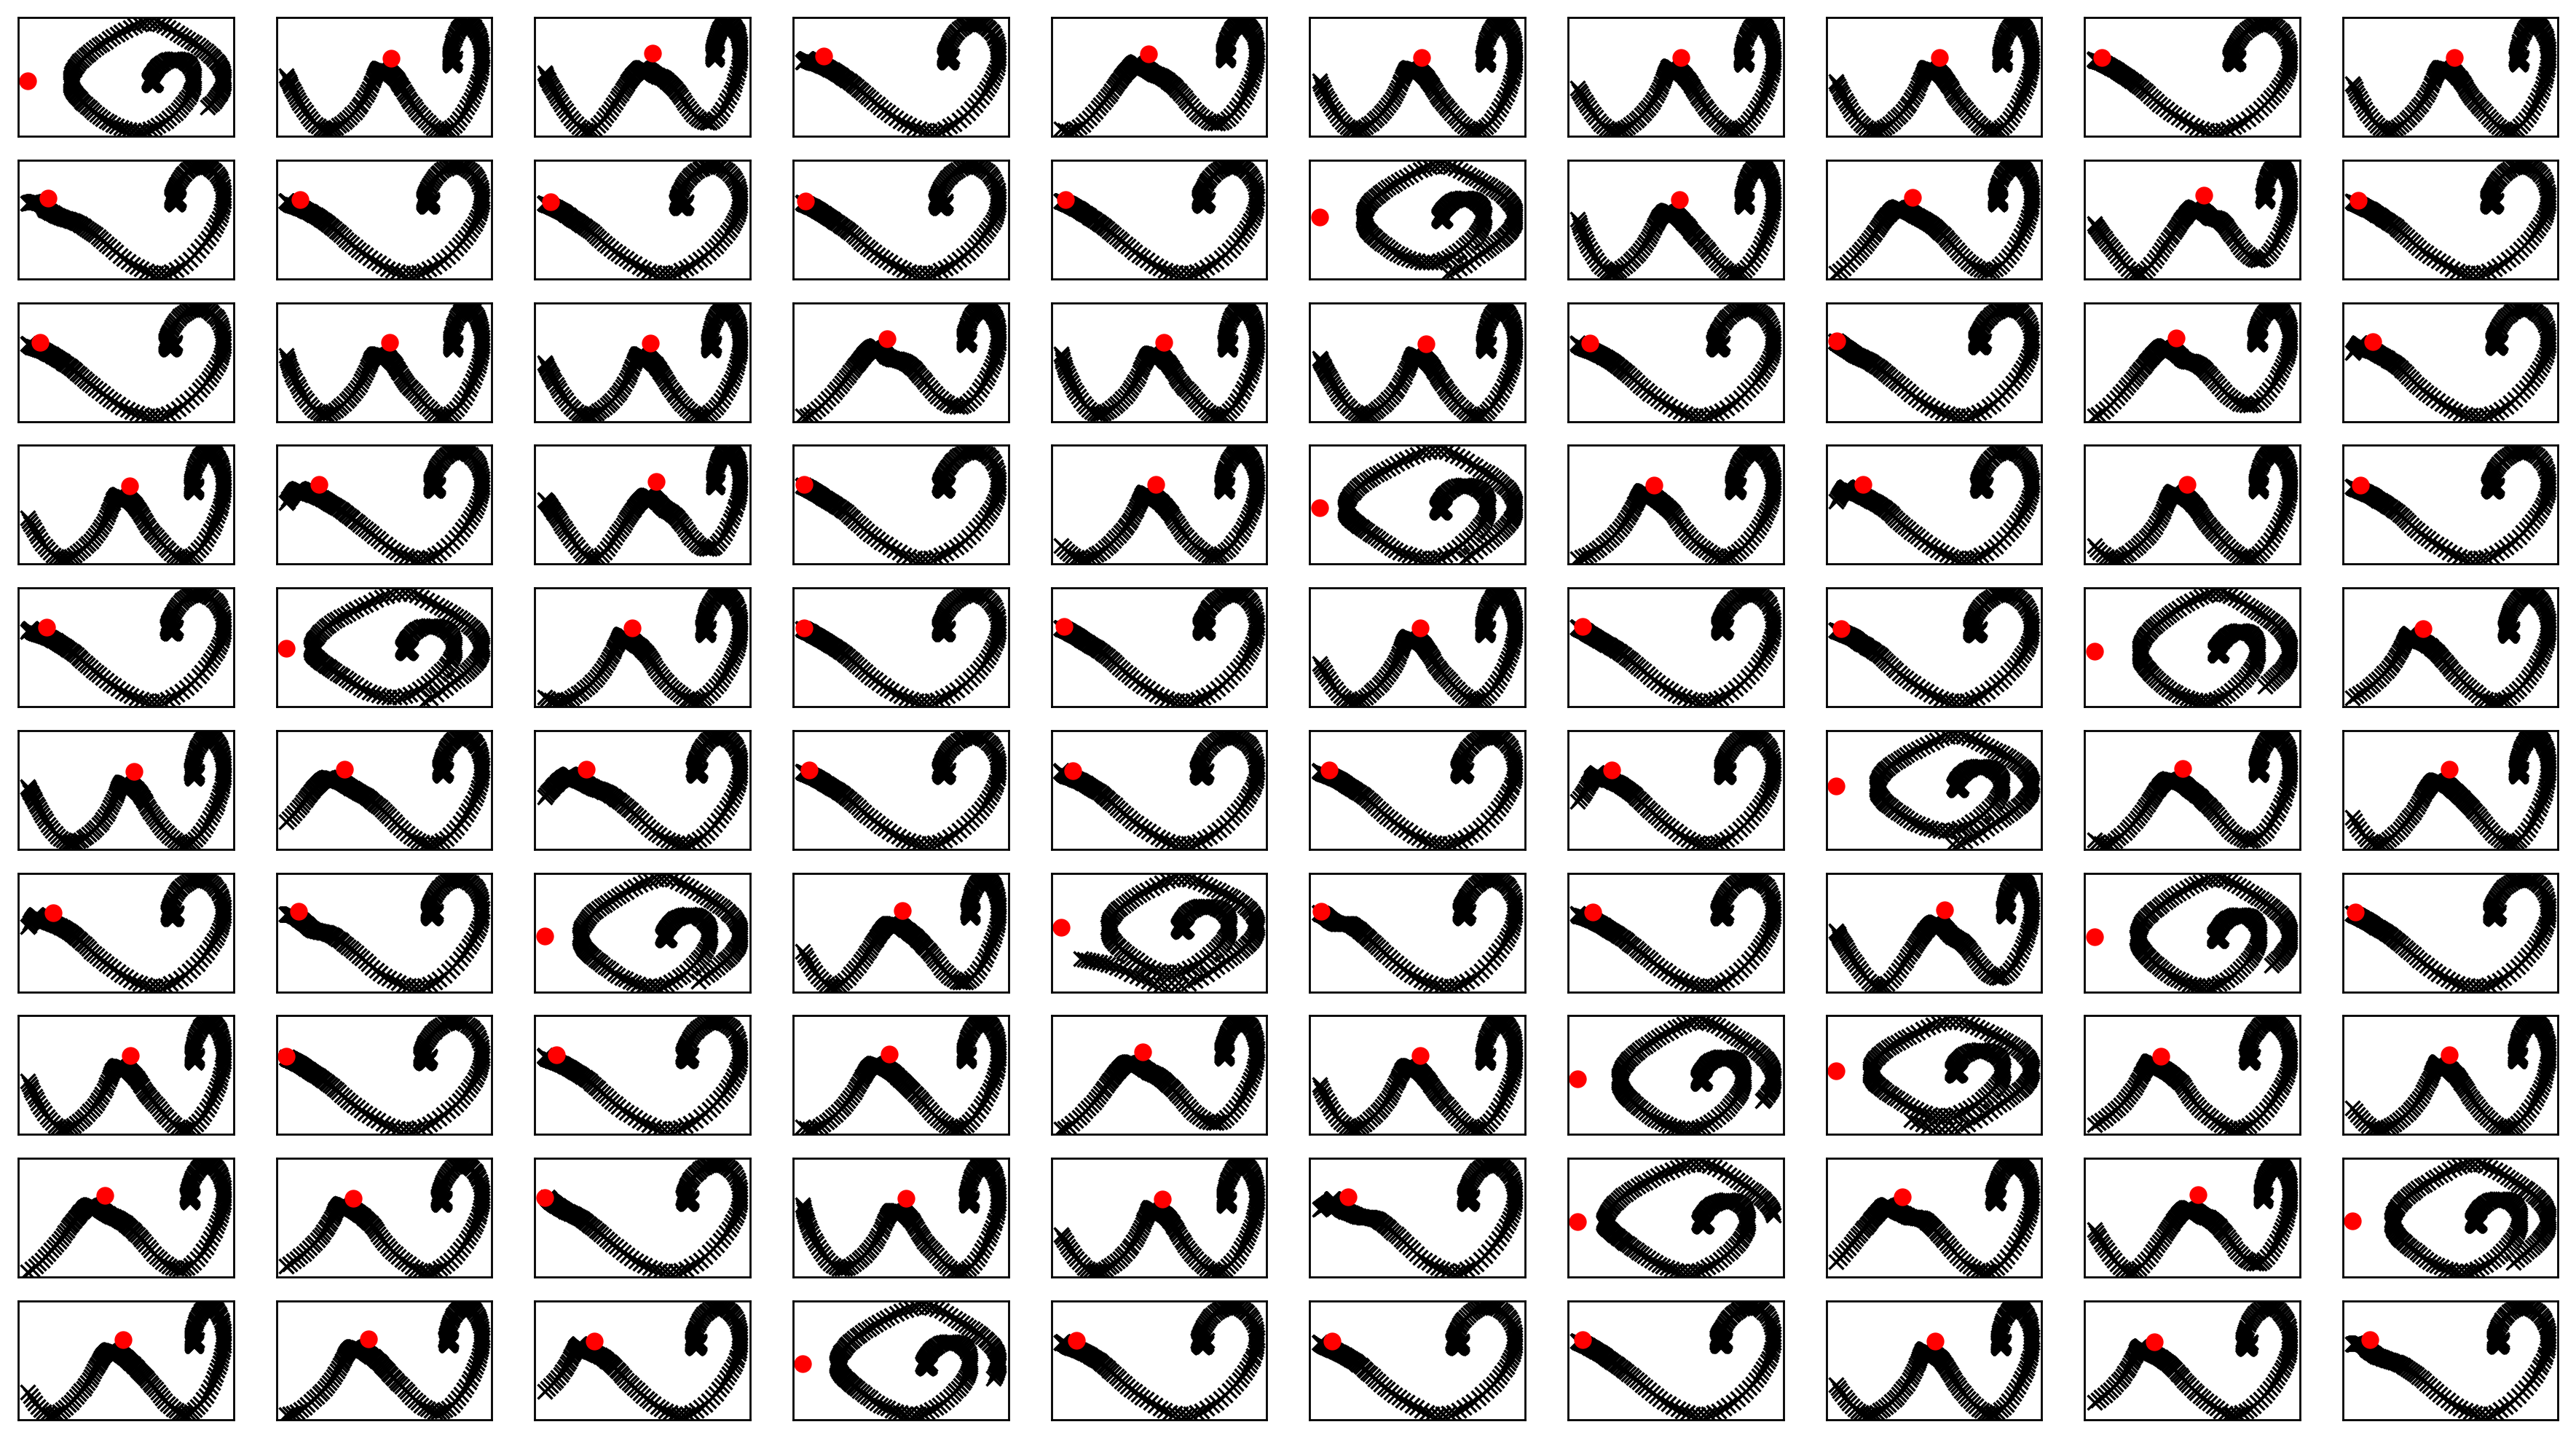

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-06-01 23:39:20.858252


# Iter 1

In [9]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [10]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.40297  validloss 1.45106±0.00000  bestvalidloss 1.45106  last_update 0
train: iter 1  trainloss 1.36423  validloss 1.36815±0.00000  bestvalidloss 1.36815  last_update 0
train: iter 2  trainloss 1.33992  validloss 1.34059±0.00000  bestvalidloss 1.34059  last_update 0
train: iter 3  trainloss 1.31330  validloss 1.31489±0.00000  bestvalidloss 1.31489  last_update 0
train: iter 4  trainloss 1.28379  validloss 1.28312±0.00000  bestvalidloss 1.28312  last_update 0
train: iter 5  trainloss 1.26043  validloss 1.25666±0.00000  bestvalidloss 1.25666  last_update 0
train: iter 6  trainloss 1.23418  validloss 1.24006±0.00000  bestvalidloss 1.24006  last_update 0
train: iter 7  trainloss 1.19732  validloss 1.20562±0.00000  bestvalidloss 1.20562  last_update 0
train: iter 8  trainloss 1.16655  validloss 1.17086±0.00000  bestvalidloss 1.17086  last_update 0
train: iter 9  trainloss 1.14402  validloss 1.13693±0.00000  bestvalidloss 1.13693  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.80667  validloss 0.85513±0.00000  bestvalidloss 0.85165  last_update 2
train: iter 84  trainloss 0.80588  validloss 0.85716±0.00000  bestvalidloss 0.85165  last_update 3
train: iter 85  trainloss 0.80645  validloss 0.85966±0.00000  bestvalidloss 0.85165  last_update 4
train: iter 86  trainloss 0.80841  validloss 0.86978±0.00000  bestvalidloss 0.85165  last_update 5
train: iter 87  trainloss 0.80837  validloss 0.85287±0.00000  bestvalidloss 0.85165  last_update 6
train: iter 88  trainloss 0.81630  validloss 0.85789±0.00000  bestvalidloss 0.85165  last_update 7
train: iter 89  trainloss 0.80967  validloss 0.86057±0.00000  bestvalidloss 0.85165  last_update 8
train: iter 90  trainloss 0.80681  validloss 0.86753±0.00000  bestvalidloss 0.85165  last_update 9
train: iter 91  trainloss 0.81145  validloss 0.85213±0.00000  bestvalidloss 0.85165  last_update 10
train: iter 92  trainloss 0.80195  validloss 0.84484±0.00000  bestvalidloss 0.84484  last_update 0
train: it

train: iter 166  trainloss 0.75422  validloss 0.79810±0.00000  bestvalidloss 0.79810  last_update 0
train: iter 167  trainloss 0.75048  validloss 0.78822±0.00000  bestvalidloss 0.78822  last_update 0
train: iter 168  trainloss 0.75946  validloss 0.81252±0.00000  bestvalidloss 0.78822  last_update 1
train: iter 169  trainloss 0.74568  validloss 0.80064±0.00000  bestvalidloss 0.78822  last_update 2
train: iter 170  trainloss 0.75551  validloss 0.80094±0.00000  bestvalidloss 0.78822  last_update 3
train: iter 171  trainloss 0.75658  validloss 0.80412±0.00000  bestvalidloss 0.78822  last_update 4
train: iter 172  trainloss 0.75380  validloss 0.79053±0.00000  bestvalidloss 0.78822  last_update 5
train: iter 173  trainloss 0.75634  validloss 0.79700±0.00000  bestvalidloss 0.78822  last_update 6
train: iter 174  trainloss 0.74627  validloss 0.78427±0.00000  bestvalidloss 0.78427  last_update 0
train: iter 175  trainloss 0.76340  validloss 0.79125±0.00000  bestvalidloss 0.78427  last_update 1


train: iter 248  trainloss 0.70872  validloss 0.73149±0.00000  bestvalidloss 0.73149  last_update 0
train: iter 249  trainloss 0.70537  validloss 0.73802±0.00000  bestvalidloss 0.73149  last_update 1
train: iter 250  trainloss 0.70334  validloss 0.75807±0.00000  bestvalidloss 0.73149  last_update 2
train: iter 251  trainloss 0.70540  validloss 0.74670±0.00000  bestvalidloss 0.73149  last_update 3
train: iter 252  trainloss 0.70781  validloss 0.74099±0.00000  bestvalidloss 0.73149  last_update 4
train: iter 253  trainloss 0.71383  validloss 0.72869±0.00000  bestvalidloss 0.72869  last_update 0
train: iter 254  trainloss 0.69884  validloss 0.73470±0.00000  bestvalidloss 0.72869  last_update 1
train: iter 255  trainloss 0.70948  validloss 0.74223±0.00000  bestvalidloss 0.72869  last_update 2
train: iter 256  trainloss 0.70820  validloss 0.72918±0.00000  bestvalidloss 0.72869  last_update 3
train: iter 257  trainloss 0.70210  validloss 0.72767±0.00000  bestvalidloss 0.72767  last_update 0


train: iter 330  trainloss 0.66842  validloss 0.69481±0.00000  bestvalidloss 0.68538  last_update 4
train: iter 331  trainloss 0.67066  validloss 0.68949±0.00000  bestvalidloss 0.68538  last_update 5
train: iter 332  trainloss 0.67698  validloss 0.71039±0.00000  bestvalidloss 0.68538  last_update 6
train: iter 333  trainloss 0.67633  validloss 0.69145±0.00000  bestvalidloss 0.68538  last_update 7
train: iter 334  trainloss 0.67498  validloss 0.68507±0.00000  bestvalidloss 0.68507  last_update 0
train: iter 335  trainloss 0.67235  validloss 0.69459±0.00000  bestvalidloss 0.68507  last_update 1
train: iter 336  trainloss 0.67105  validloss 0.70268±0.00000  bestvalidloss 0.68507  last_update 2
train: iter 337  trainloss 0.67951  validloss 0.69246±0.00000  bestvalidloss 0.68507  last_update 3
train: iter 338  trainloss 0.67881  validloss 0.70553±0.00000  bestvalidloss 0.68507  last_update 4
train: iter 339  trainloss 0.67641  validloss 0.67662±0.00000  bestvalidloss 0.67662  last_update 0


train: iter 412  trainloss 0.65574  validloss 0.65748±0.00000  bestvalidloss 0.65101  last_update 6
train: iter 413  trainloss 0.64908  validloss 0.65842±0.00000  bestvalidloss 0.65101  last_update 7
train: iter 414  trainloss 0.65031  validloss 0.65860±0.00000  bestvalidloss 0.65101  last_update 8
train: iter 415  trainloss 0.64624  validloss 0.65456±0.00000  bestvalidloss 0.65101  last_update 9
train: iter 416  trainloss 0.64919  validloss 0.66560±0.00000  bestvalidloss 0.65101  last_update 10
train: iter 417  trainloss 0.64834  validloss 0.67650±0.00000  bestvalidloss 0.65101  last_update 11
train: iter 418  trainloss 0.65154  validloss 0.68076±0.00000  bestvalidloss 0.65101  last_update 12
train: iter 419  trainloss 0.64098  validloss 0.65596±0.00000  bestvalidloss 0.65101  last_update 13
train: iter 420  trainloss 0.64402  validloss 0.66852±0.00000  bestvalidloss 0.65101  last_update 14
train: iter 421  trainloss 0.65251  validloss 0.66783±0.00000  bestvalidloss 0.65101  last_upda

train: iter 494  trainloss 0.62742  validloss 0.63671±0.00000  bestvalidloss 0.63053  last_update 2
train: iter 495  trainloss 0.63302  validloss 0.64332±0.00000  bestvalidloss 0.63053  last_update 3
train: iter 496  trainloss 0.62526  validloss 0.64311±0.00000  bestvalidloss 0.63053  last_update 4
train: iter 497  trainloss 0.63704  validloss 0.63015±0.00000  bestvalidloss 0.63015  last_update 0
train: iter 498  trainloss 0.63945  validloss 0.67300±0.00000  bestvalidloss 0.63015  last_update 1
train: iter 499  trainloss 0.63234  validloss 0.67083±0.00000  bestvalidloss 0.63015  last_update 2
train: iter 500  trainloss 0.62281  validloss 0.64374±0.00000  bestvalidloss 0.63015  last_update 3
train: iter 501  trainloss 0.62516  validloss 0.64717±0.00000  bestvalidloss 0.63015  last_update 4
train: iter 502  trainloss 0.63131  validloss 0.65413±0.00000  bestvalidloss 0.63015  last_update 5
train: iter 503  trainloss 0.63624  validloss 0.70930±0.00000  bestvalidloss 0.63015  last_update 6


train: iter 576  trainloss 0.61003  validloss 0.62615±0.00000  bestvalidloss 0.61977  last_update 3
train: iter 577  trainloss 0.60651  validloss 0.62473±0.00000  bestvalidloss 0.61977  last_update 4
train: iter 578  trainloss 0.61052  validloss 0.62441±0.00000  bestvalidloss 0.61977  last_update 5
train: iter 579  trainloss 0.60542  validloss 0.62168±0.00000  bestvalidloss 0.61977  last_update 6
train: iter 580  trainloss 0.61065  validloss 0.63076±0.00000  bestvalidloss 0.61977  last_update 7
train: iter 581  trainloss 0.61209  validloss 0.62763±0.00000  bestvalidloss 0.61977  last_update 8
train: iter 582  trainloss 0.60825  validloss 0.63047±0.00000  bestvalidloss 0.61977  last_update 9
train: iter 583  trainloss 0.60716  validloss 0.62864±0.00000  bestvalidloss 0.61977  last_update 10
train: iter 584  trainloss 0.61114  validloss 0.62848±0.00000  bestvalidloss 0.61977  last_update 11
train: iter 585  trainloss 0.61605  validloss 0.67627±0.00000  bestvalidloss 0.61977  last_update 

train: iter 659  trainloss 0.59777  validloss 0.62113±0.00000  bestvalidloss 0.60917  last_update 10
train: iter 660  trainloss 0.59359  validloss 0.60546±0.00000  bestvalidloss 0.60546  last_update 0
train: iter 661  trainloss 0.58562  validloss 0.61731±0.00000  bestvalidloss 0.60546  last_update 1
train: iter 662  trainloss 0.59636  validloss 0.62675±0.00000  bestvalidloss 0.60546  last_update 2
train: iter 663  trainloss 0.59995  validloss 0.65512±0.00000  bestvalidloss 0.60546  last_update 3
train: iter 664  trainloss 0.59429  validloss 0.63357±0.00000  bestvalidloss 0.60546  last_update 4
train: iter 665  trainloss 0.59154  validloss 0.61083±0.00000  bestvalidloss 0.60546  last_update 5
train: iter 666  trainloss 0.58812  validloss 0.62696±0.00000  bestvalidloss 0.60546  last_update 6
train: iter 667  trainloss 0.59200  validloss 0.61171±0.00000  bestvalidloss 0.60546  last_update 7
train: iter 668  trainloss 0.59640  validloss 0.61239±0.00000  bestvalidloss 0.60546  last_update 8

train: iter 741  trainloss 0.58030  validloss 0.63267±0.00000  bestvalidloss 0.60546  last_update 81
train: iter 742  trainloss 0.57260  validloss 0.62268±0.00000  bestvalidloss 0.60546  last_update 82
train: iter 743  trainloss 0.58020  validloss 0.61118±0.00000  bestvalidloss 0.60546  last_update 83
train: iter 744  trainloss 0.57464  validloss 0.62267±0.00000  bestvalidloss 0.60546  last_update 84
train: iter 745  trainloss 0.57380  validloss 0.63279±0.00000  bestvalidloss 0.60546  last_update 85
train: iter 746  trainloss 0.57919  validloss 0.66573±0.00000  bestvalidloss 0.60546  last_update 86
train: iter 747  trainloss 0.57273  validloss 0.61258±0.00000  bestvalidloss 0.60546  last_update 87
train: iter 748  trainloss 0.56917  validloss 0.61207±0.00000  bestvalidloss 0.60546  last_update 88
train: iter 749  trainloss 0.58590  validloss 0.63417±0.00000  bestvalidloss 0.60546  last_update 89
train: iter 750  trainloss 0.58628  validloss 0.62163±0.00000  bestvalidloss 0.60546  last_

train: iter 823  trainloss 0.56222  validloss 0.63862±0.00000  bestvalidloss 0.60120  last_update 6
train: iter 824  trainloss 0.56101  validloss 0.61367±0.00000  bestvalidloss 0.60120  last_update 7
train: iter 825  trainloss 0.56322  validloss 0.60618±0.00000  bestvalidloss 0.60120  last_update 8
train: iter 826  trainloss 0.56428  validloss 0.61751±0.00000  bestvalidloss 0.60120  last_update 9
train: iter 827  trainloss 0.56657  validloss 0.61389±0.00000  bestvalidloss 0.60120  last_update 10
train: iter 828  trainloss 0.56380  validloss 0.61179±0.00000  bestvalidloss 0.60120  last_update 11
train: iter 829  trainloss 0.56105  validloss 0.60273±0.00000  bestvalidloss 0.60120  last_update 12
train: iter 830  trainloss 0.56228  validloss 0.60385±0.00000  bestvalidloss 0.60120  last_update 13
train: iter 831  trainloss 0.56040  validloss 0.61261±0.00000  bestvalidloss 0.60120  last_update 14
train: iter 832  trainloss 0.56199  validloss 0.60717±0.00000  bestvalidloss 0.60120  last_upda

train: iter 905  trainloss 0.55026  validloss 0.60841±0.00000  bestvalidloss 0.60120  last_update 88
train: iter 906  trainloss 0.55353  validloss 0.62010±0.00000  bestvalidloss 0.60120  last_update 89
train: iter 907  trainloss 0.54814  validloss 0.61942±0.00000  bestvalidloss 0.60120  last_update 90
train: iter 908  trainloss 0.55313  validloss 0.60009±0.00000  bestvalidloss 0.60009  last_update 0
train: iter 909  trainloss 0.55348  validloss 0.61911±0.00000  bestvalidloss 0.60009  last_update 1
train: iter 910  trainloss 0.54387  validloss 0.63031±0.00000  bestvalidloss 0.60009  last_update 2
train: iter 911  trainloss 0.55038  validloss 0.61814±0.00000  bestvalidloss 0.60009  last_update 3
train: iter 912  trainloss 0.54944  validloss 0.60655±0.00000  bestvalidloss 0.60009  last_update 4
train: iter 913  trainloss 0.54735  validloss 0.60567±0.00000  bestvalidloss 0.60009  last_update 5
train: iter 914  trainloss 0.54479  validloss 0.60255±0.00000  bestvalidloss 0.60009  last_update

train: iter 987  trainloss 0.54221  validloss 0.63142±0.00000  bestvalidloss 0.59766  last_update 12
train: iter 988  trainloss 0.54376  validloss 0.61297±0.00000  bestvalidloss 0.59766  last_update 13
train: iter 989  trainloss 0.53693  validloss 0.60814±0.00000  bestvalidloss 0.59766  last_update 14
train: iter 990  trainloss 0.53514  validloss 0.61264±0.00000  bestvalidloss 0.59766  last_update 15
train: iter 991  trainloss 0.53567  validloss 0.61844±0.00000  bestvalidloss 0.59766  last_update 16
train: iter 992  trainloss 0.54415  validloss 0.62208±0.00000  bestvalidloss 0.59766  last_update 17
train: iter 993  trainloss 0.53271  validloss 0.60684±0.00000  bestvalidloss 0.59766  last_update 18
train: iter 994  trainloss 0.53800  validloss 0.61009±0.00000  bestvalidloss 0.59766  last_update 19
train: iter 995  trainloss 0.53585  validloss 0.59939±0.00000  bestvalidloss 0.59766  last_update 20
train: iter 996  trainloss 0.53425  validloss 0.60791±0.00000  bestvalidloss 0.59766  last_

train: iter 1068  trainloss 0.52427  validloss 0.59906±0.00000  bestvalidloss 0.59388  last_update 42
train: iter 1069  trainloss 0.52161  validloss 0.60417±0.00000  bestvalidloss 0.59388  last_update 43
train: iter 1070  trainloss 0.52310  validloss 0.59843±0.00000  bestvalidloss 0.59388  last_update 44
train: iter 1071  trainloss 0.52500  validloss 0.60410±0.00000  bestvalidloss 0.59388  last_update 45
train: iter 1072  trainloss 0.52454  validloss 0.61095±0.00000  bestvalidloss 0.59388  last_update 46
train: iter 1073  trainloss 0.53035  validloss 0.60565±0.00000  bestvalidloss 0.59388  last_update 47
train: iter 1074  trainloss 0.52231  validloss 0.59720±0.00000  bestvalidloss 0.59388  last_update 48
train: iter 1075  trainloss 0.52338  validloss 0.59937±0.00000  bestvalidloss 0.59388  last_update 49
train: iter 1076  trainloss 0.53021  validloss 0.61313±0.00000  bestvalidloss 0.59388  last_update 50
train: iter 1077  trainloss 0.52756  validloss 0.60334±0.00000  bestvalidloss 0.59

train: iter 1149  trainloss 0.51107  validloss 0.62078±0.00000  bestvalidloss 0.59095  last_update 16
train: iter 1150  trainloss 0.51395  validloss 0.59136±0.00000  bestvalidloss 0.59095  last_update 17
train: iter 1151  trainloss 0.51635  validloss 0.60701±0.00000  bestvalidloss 0.59095  last_update 18
train: iter 1152  trainloss 0.51223  validloss 0.60935±0.00000  bestvalidloss 0.59095  last_update 19
train: iter 1153  trainloss 0.51347  validloss 0.59733±0.00000  bestvalidloss 0.59095  last_update 20
train: iter 1154  trainloss 0.51345  validloss 0.60608±0.00000  bestvalidloss 0.59095  last_update 21
train: iter 1155  trainloss 0.52458  validloss 0.63075±0.00000  bestvalidloss 0.59095  last_update 22
train: iter 1156  trainloss 0.52202  validloss 0.59759±0.00000  bestvalidloss 0.59095  last_update 23
train: iter 1157  trainloss 0.51792  validloss 0.61315±0.00000  bestvalidloss 0.59095  last_update 24
train: iter 1158  trainloss 0.51514  validloss 0.59229±0.00000  bestvalidloss 0.59

train: iter 1230  trainloss 0.50631  validloss 0.60103±0.00000  bestvalidloss 0.58516  last_update 31
train: iter 1231  trainloss 0.50400  validloss 0.59570±0.00000  bestvalidloss 0.58516  last_update 32
train: iter 1232  trainloss 0.50278  validloss 0.60738±0.00000  bestvalidloss 0.58516  last_update 33
train: iter 1233  trainloss 0.50272  validloss 0.60059±0.00000  bestvalidloss 0.58516  last_update 34
train: iter 1234  trainloss 0.50199  validloss 0.59292±0.00000  bestvalidloss 0.58516  last_update 35
train: iter 1235  trainloss 0.50408  validloss 0.58916±0.00000  bestvalidloss 0.58516  last_update 36
train: iter 1236  trainloss 0.50246  validloss 0.61867±0.00000  bestvalidloss 0.58516  last_update 37
train: iter 1237  trainloss 0.50552  validloss 0.59441±0.00000  bestvalidloss 0.58516  last_update 38
train: iter 1238  trainloss 0.50871  validloss 0.60150±0.00000  bestvalidloss 0.58516  last_update 39
train: iter 1239  trainloss 0.50233  validloss 0.59663±0.00000  bestvalidloss 0.58

train: iter 1311  trainloss 0.49692  validloss 0.59960±0.00000  bestvalidloss 0.58422  last_update 36
train: iter 1312  trainloss 0.49166  validloss 0.58712±0.00000  bestvalidloss 0.58422  last_update 37
train: iter 1313  trainloss 0.49614  validloss 0.61683±0.00000  bestvalidloss 0.58422  last_update 38
train: iter 1314  trainloss 0.49527  validloss 0.59833±0.00000  bestvalidloss 0.58422  last_update 39
train: iter 1315  trainloss 0.49796  validloss 0.62330±0.00000  bestvalidloss 0.58422  last_update 40
train: iter 1316  trainloss 0.49169  validloss 0.59008±0.00000  bestvalidloss 0.58422  last_update 41
train: iter 1317  trainloss 0.49364  validloss 0.60709±0.00000  bestvalidloss 0.58422  last_update 42
train: iter 1318  trainloss 0.49459  validloss 0.58692±0.00000  bestvalidloss 0.58422  last_update 43
train: iter 1319  trainloss 0.49479  validloss 0.59361±0.00000  bestvalidloss 0.58422  last_update 44
train: iter 1320  trainloss 0.49345  validloss 0.61749±0.00000  bestvalidloss 0.58

train: iter 1392  trainloss 0.48578  validloss 0.59414±0.00000  bestvalidloss 0.57494  last_update 61
train: iter 1393  trainloss 0.48441  validloss 0.58992±0.00000  bestvalidloss 0.57494  last_update 62
train: iter 1394  trainloss 0.48156  validloss 0.58503±0.00000  bestvalidloss 0.57494  last_update 63
train: iter 1395  trainloss 0.48438  validloss 0.59556±0.00000  bestvalidloss 0.57494  last_update 64
train: iter 1396  trainloss 0.48488  validloss 0.58477±0.00000  bestvalidloss 0.57494  last_update 65
train: iter 1397  trainloss 0.48380  validloss 0.60078±0.00000  bestvalidloss 0.57494  last_update 66
train: iter 1398  trainloss 0.49221  validloss 0.62377±0.00000  bestvalidloss 0.57494  last_update 67
train: iter 1399  trainloss 0.48518  validloss 0.58012±0.00000  bestvalidloss 0.57494  last_update 68
train: iter 1400  trainloss 0.48081  validloss 0.58160±0.00000  bestvalidloss 0.57494  last_update 69
train: iter 1401  trainloss 0.48527  validloss 0.59166±0.00000  bestvalidloss 0.57

train: iter 1473  trainloss 0.47631  validloss 0.58330±0.00000  bestvalidloss 0.57319  last_update 46
train: iter 1474  trainloss 0.47045  validloss 0.58542±0.00000  bestvalidloss 0.57319  last_update 47
train: iter 1475  trainloss 0.47479  validloss 0.58420±0.00000  bestvalidloss 0.57319  last_update 48
train: iter 1476  trainloss 0.47150  validloss 0.59176±0.00000  bestvalidloss 0.57319  last_update 49
train: iter 1477  trainloss 0.47310  validloss 0.58023±0.00000  bestvalidloss 0.57319  last_update 50
train: iter 1478  trainloss 0.47670  validloss 0.58785±0.00000  bestvalidloss 0.57319  last_update 51
train: iter 1479  trainloss 0.47126  validloss 0.57527±0.00000  bestvalidloss 0.57319  last_update 52
train: iter 1480  trainloss 0.47288  validloss 0.57838±0.00000  bestvalidloss 0.57319  last_update 53
train: iter 1481  trainloss 0.48192  validloss 0.58100±0.00000  bestvalidloss 0.57319  last_update 54
train: iter 1482  trainloss 0.47964  validloss 0.58088±0.00000  bestvalidloss 0.57

train: iter 1554  trainloss 0.46176  validloss 0.58912±0.00000  bestvalidloss 0.56176  last_update 12
train: iter 1555  trainloss 0.46642  validloss 0.57752±0.00000  bestvalidloss 0.56176  last_update 13
train: iter 1556  trainloss 0.46463  validloss 0.57317±0.00000  bestvalidloss 0.56176  last_update 14
train: iter 1557  trainloss 0.46686  validloss 0.57248±0.00000  bestvalidloss 0.56176  last_update 15
train: iter 1558  trainloss 0.46916  validloss 0.58347±0.00000  bestvalidloss 0.56176  last_update 16
train: iter 1559  trainloss 0.46575  validloss 0.57884±0.00000  bestvalidloss 0.56176  last_update 17
train: iter 1560  trainloss 0.46401  validloss 0.58358±0.00000  bestvalidloss 0.56176  last_update 18
train: iter 1561  trainloss 0.46477  validloss 0.56580±0.00000  bestvalidloss 0.56176  last_update 19
train: iter 1562  trainloss 0.46613  validloss 0.57829±0.00000  bestvalidloss 0.56176  last_update 20
train: iter 1563  trainloss 0.45928  validloss 0.58042±0.00000  bestvalidloss 0.56

train: iter 1635  trainloss 0.45492  validloss 0.57126±0.00000  bestvalidloss 0.55220  last_update 6
train: iter 1636  trainloss 0.45740  validloss 0.56369±0.00000  bestvalidloss 0.55220  last_update 7
train: iter 1637  trainloss 0.45570  validloss 0.56280±0.00000  bestvalidloss 0.55220  last_update 8
train: iter 1638  trainloss 0.45544  validloss 0.56934±0.00000  bestvalidloss 0.55220  last_update 9
train: iter 1639  trainloss 0.45655  validloss 0.56004±0.00000  bestvalidloss 0.55220  last_update 10
train: iter 1640  trainloss 0.45684  validloss 0.56573±0.00000  bestvalidloss 0.55220  last_update 11
train: iter 1641  trainloss 0.45458  validloss 0.57455±0.00000  bestvalidloss 0.55220  last_update 12
train: iter 1642  trainloss 0.45484  validloss 0.58683±0.00000  bestvalidloss 0.55220  last_update 13
train: iter 1643  trainloss 0.45555  validloss 0.55405±0.00000  bestvalidloss 0.55220  last_update 14
train: iter 1644  trainloss 0.46123  validloss 0.56562±0.00000  bestvalidloss 0.55220 

train: iter 1716  trainloss 0.45270  validloss 0.59498±0.00000  bestvalidloss 0.55097  last_update 24
train: iter 1717  trainloss 0.45125  validloss 0.57843±0.00000  bestvalidloss 0.55097  last_update 25
train: iter 1718  trainloss 0.45111  validloss 0.56995±0.00000  bestvalidloss 0.55097  last_update 26
train: iter 1719  trainloss 0.44584  validloss 0.55743±0.00000  bestvalidloss 0.55097  last_update 27
train: iter 1720  trainloss 0.44605  validloss 0.56184±0.00000  bestvalidloss 0.55097  last_update 28
train: iter 1721  trainloss 0.44759  validloss 0.55783±0.00000  bestvalidloss 0.55097  last_update 29
train: iter 1722  trainloss 0.44961  validloss 0.55780±0.00000  bestvalidloss 0.55097  last_update 30
train: iter 1723  trainloss 0.44743  validloss 0.56466±0.00000  bestvalidloss 0.55097  last_update 31
train: iter 1724  trainloss 0.44522  validloss 0.56330±0.00000  bestvalidloss 0.55097  last_update 32
train: iter 1725  trainloss 0.45021  validloss 0.55313±0.00000  bestvalidloss 0.55

train: iter 1798  trainloss 0.43925  validloss 0.57519±0.00000  bestvalidloss 0.54624  last_update 12
train: iter 1799  trainloss 0.43908  validloss 0.55357±0.00000  bestvalidloss 0.54624  last_update 13
train: iter 1800  trainloss 0.43461  validloss 0.55495±0.00000  bestvalidloss 0.54624  last_update 14
train: iter 1801  trainloss 0.44047  validloss 0.55110±0.00000  bestvalidloss 0.54624  last_update 15
train: iter 1802  trainloss 0.44100  validloss 0.56767±0.00000  bestvalidloss 0.54624  last_update 16
train: iter 1803  trainloss 0.43248  validloss 0.55189±0.00000  bestvalidloss 0.54624  last_update 17
train: iter 1804  trainloss 0.43890  validloss 0.55018±0.00000  bestvalidloss 0.54624  last_update 18
train: iter 1805  trainloss 0.43163  validloss 0.57991±0.00000  bestvalidloss 0.54624  last_update 19
train: iter 1806  trainloss 0.44042  validloss 0.56083±0.00000  bestvalidloss 0.54624  last_update 20
train: iter 1807  trainloss 0.43902  validloss 0.57793±0.00000  bestvalidloss 0.54

train: iter 1879  trainloss 0.42672  validloss 0.57965±0.00000  bestvalidloss 0.54424  last_update 59
train: iter 1880  trainloss 0.42929  validloss 0.55706±0.00000  bestvalidloss 0.54424  last_update 60
train: iter 1881  trainloss 0.42750  validloss 0.56357±0.00000  bestvalidloss 0.54424  last_update 61
train: iter 1882  trainloss 0.43118  validloss 0.56429±0.00000  bestvalidloss 0.54424  last_update 62
train: iter 1883  trainloss 0.42936  validloss 0.56892±0.00000  bestvalidloss 0.54424  last_update 63
train: iter 1884  trainloss 0.43089  validloss 0.56101±0.00000  bestvalidloss 0.54424  last_update 64
train: iter 1885  trainloss 0.42555  validloss 0.59492±0.00000  bestvalidloss 0.54424  last_update 65
train: iter 1886  trainloss 0.42427  validloss 0.58314±0.00000  bestvalidloss 0.54424  last_update 66
train: iter 1887  trainloss 0.43052  validloss 0.60168±0.00000  bestvalidloss 0.54424  last_update 67
train: iter 1888  trainloss 0.42603  validloss 0.56738±0.00000  bestvalidloss 0.54

([1.40296568274498,
  1.3642343953251839,
  1.3399212911725045,
  1.3132985040545464,
  1.2837946623563767,
  1.2604306109249592,
  1.2341816678643227,
  1.1973215810954572,
  1.1665477178990842,
  1.1440182708203792,
  1.1169696249067784,
  1.0981759503483772,
  1.078546830266714,
  1.0718873754143714,
  1.0525146126747131,
  1.0437474086880685,
  1.0350204288959504,
  1.0195998437702656,
  1.0141331769526005,
  1.0066202599555254,
  0.9932311702519655,
  0.9872609857469797,
  0.976653004810214,
  0.9694192588329316,
  0.9670148935168982,
  0.9547843176871538,
  0.9499206747859716,
  0.9441672038286925,
  0.9386439103633165,
  0.9356653064489364,
  0.9303640235215426,
  0.919109207764268,
  0.9259735736995935,
  0.916853029280901,
  0.9150912459939718,
  0.9034425847232341,
  0.9027912255376578,
  0.8974489413201809,
  0.9055316329002381,
  0.8954851485788822,
  0.8829113129526377,
  0.8852304499596357,
  0.8990388426929712,
  0.8758545905351639,
  0.8731453821063042,
  0.874759177863

In [11]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -3.9214096091836694
valid_loss:  -5.9910271178960794
weight_alpha 1.0 h_min_tilde -12.323891 ell_tilde -4.335333110926151 kappa_tilde 0.0003538065064072142
train_loss:  -6.2849963241577145
valid_loss:  -6.094129262542724
weight_alpha 0.1 h_min_tilde -12.323891 ell_tilde -6.246822911834716 kappa_tilde 0.0004056513821767928


In [12]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1295.40137  validloss -1218.30117±0.00000  bestvalidloss -1218.30117  last_update 0
train: iter 1  trainloss -1277.01415  validloss -1227.35929±0.00000  bestvalidloss -1227.35929  last_update 0
train: iter 2  trainloss -1285.42747  validloss -1208.28090±0.00000  bestvalidloss -1227.35929  last_update 1
train: iter 3  trainloss -1306.87992  validloss -1209.04202±0.00000  bestvalidloss -1227.35929  last_update 2
train: iter 4  trainloss -1269.24735  validloss -1201.35541±0.00000  bestvalidloss -1227.35929  last_update 3
train: iter 5  trainloss -1296.63729  validloss -1213.68534±0.00000  bestvalidloss -1227.35929  last_update 4
train: iter 6  trainloss -1318.01692  validloss -1263.23077±0.00000  bestvalidloss -1263.23077  last_update 0
train: iter 7  trainloss -1276.11508  validloss -1212.95775±0.00000  bestvalidloss -1263.23077  last_update 1
train: iter 8  trainloss -1297.18328  validloss -1250.55699±0.00000  bestva

train: iter 74  trainloss -1353.68182  validloss -1222.08441±0.00000  bestvalidloss -1321.86765  last_update 41
train: iter 75  trainloss -1322.53030  validloss -1225.68756±0.00000  bestvalidloss -1321.86765  last_update 42
train: iter 76  trainloss -1346.54698  validloss -1264.43329±0.00000  bestvalidloss -1321.86765  last_update 43
train: iter 77  trainloss -1378.99279  validloss -1247.99089±0.00000  bestvalidloss -1321.86765  last_update 44
train: iter 78  trainloss -1346.34076  validloss -1213.90737±0.00000  bestvalidloss -1321.86765  last_update 45
train: iter 79  trainloss -1364.31140  validloss -1269.65992±0.00000  bestvalidloss -1321.86765  last_update 46
train: iter 80  trainloss -1373.39910  validloss -1276.66041±0.00000  bestvalidloss -1321.86765  last_update 47
train: iter 81  trainloss -1365.52957  validloss -1292.05586±0.00000  bestvalidloss -1321.86765  last_update 48
train: iter 82  trainloss -1401.40576  validloss -1297.31200±0.00000  bestvalidloss -1321.86765  last_up

train: iter 147  trainloss -1424.41040  validloss -1291.93169±0.00000  bestvalidloss -1340.42338  last_update 2
train: iter 148  trainloss -1426.20532  validloss -1263.13929±0.00000  bestvalidloss -1340.42338  last_update 3
train: iter 149  trainloss -1400.01885  validloss -1249.73702±0.00000  bestvalidloss -1340.42338  last_update 4
train: iter 150  trainloss -1417.16379  validloss -1285.87698±0.00000  bestvalidloss -1340.42338  last_update 5
train: iter 151  trainloss -1385.70472  validloss -1251.77564±0.00000  bestvalidloss -1340.42338  last_update 6
train: iter 152  trainloss -1419.23155  validloss -1299.90818±0.00000  bestvalidloss -1340.42338  last_update 7
train: iter 153  trainloss -1425.86454  validloss -1275.05228±0.00000  bestvalidloss -1340.42338  last_update 8
train: iter 154  trainloss -1395.56608  validloss -1290.89678±0.00000  bestvalidloss -1340.42338  last_update 9
train: iter 155  trainloss -1428.70755  validloss -1302.68734±0.00000  bestvalidloss -1340.42338  last_u

train: iter 220  trainloss -1462.95526  validloss -1330.78787±0.00000  bestvalidloss -1368.15183  last_update 16
train: iter 221  trainloss -1424.92113  validloss -1275.98448±0.00000  bestvalidloss -1368.15183  last_update 17
train: iter 222  trainloss -1413.45318  validloss -1266.35719±0.00000  bestvalidloss -1368.15183  last_update 18
train: iter 223  trainloss -1478.65585  validloss -1292.15269±0.00000  bestvalidloss -1368.15183  last_update 19
train: iter 224  trainloss -1461.03578  validloss -1320.37603±0.00000  bestvalidloss -1368.15183  last_update 20
train: iter 225  trainloss -1475.21822  validloss -1271.70609±0.00000  bestvalidloss -1368.15183  last_update 21
train: iter 226  trainloss -1497.04299  validloss -1341.16874±0.00000  bestvalidloss -1368.15183  last_update 22
train: iter 227  trainloss -1471.12155  validloss -1349.59032±0.00000  bestvalidloss -1368.15183  last_update 23
train: iter 228  trainloss -1441.57490  validloss -1289.84518±0.00000  bestvalidloss -1368.15183

train: iter 293  trainloss -1488.78890  validloss -1321.81223±0.00000  bestvalidloss -1368.15575  last_update 35
train: iter 294  trainloss -1394.18106  validloss -1242.90599±0.00000  bestvalidloss -1368.15575  last_update 36
train: iter 295  trainloss -1485.79498  validloss -1345.69545±0.00000  bestvalidloss -1368.15575  last_update 37
train: iter 296  trainloss -1483.59826  validloss -1314.44642±0.00000  bestvalidloss -1368.15575  last_update 38
train: iter 297  trainloss -1501.12666  validloss -1337.44876±0.00000  bestvalidloss -1368.15575  last_update 39
train: iter 298  trainloss -1505.20703  validloss -1336.93554±0.00000  bestvalidloss -1368.15575  last_update 40
train: iter 299  trainloss -1498.80442  validloss -1345.22638±0.00000  bestvalidloss -1368.15575  last_update 41
train: iter 300  trainloss -1525.49836  validloss -1338.74138±0.00000  bestvalidloss -1368.15575  last_update 42
train: iter 301  trainloss -1490.31182  validloss -1304.02455±0.00000  bestvalidloss -1368.15575

train: iter 366  trainloss -1543.10000  validloss -1376.23187±0.00000  bestvalidloss -1376.23187  last_update 0
train: iter 367  trainloss -1547.13892  validloss -1322.03299±0.00000  bestvalidloss -1376.23187  last_update 1
train: iter 368  trainloss -1553.60615  validloss -1375.87187±0.00000  bestvalidloss -1376.23187  last_update 2
train: iter 369  trainloss -1530.36148  validloss -1366.83745±0.00000  bestvalidloss -1376.23187  last_update 3
train: iter 370  trainloss -1539.35320  validloss -1344.52404±0.00000  bestvalidloss -1376.23187  last_update 4
train: iter 371  trainloss -1543.45151  validloss -1344.85412±0.00000  bestvalidloss -1376.23187  last_update 5
train: iter 372  trainloss -1553.43879  validloss -1341.58842±0.00000  bestvalidloss -1376.23187  last_update 6
train: iter 373  trainloss -1523.71584  validloss -1341.52918±0.00000  bestvalidloss -1376.23187  last_update 7
train: iter 374  trainloss -1532.69531  validloss -1382.63718±0.00000  bestvalidloss -1382.63718  last_u

train: iter 439  trainloss -1549.39305  validloss -1340.53719±0.00000  bestvalidloss -1388.06414  last_update 44
train: iter 440  trainloss -1529.10492  validloss -1354.01729±0.00000  bestvalidloss -1388.06414  last_update 45
train: iter 441  trainloss -1562.07506  validloss -1362.94051±0.00000  bestvalidloss -1388.06414  last_update 46
train: iter 442  trainloss -1550.74039  validloss -1361.52958±0.00000  bestvalidloss -1388.06414  last_update 47
train: iter 443  trainloss -1537.68498  validloss -1346.31150±0.00000  bestvalidloss -1388.06414  last_update 48
train: iter 444  trainloss -1551.53726  validloss -1355.61954±0.00000  bestvalidloss -1388.06414  last_update 49
train: iter 445  trainloss -1570.85219  validloss -1346.91059±0.00000  bestvalidloss -1388.06414  last_update 50
train: iter 446  trainloss -1558.45660  validloss -1373.18026±0.00000  bestvalidloss -1388.06414  last_update 51
train: iter 447  trainloss -1559.92267  validloss -1384.58423±0.00000  bestvalidloss -1388.06414

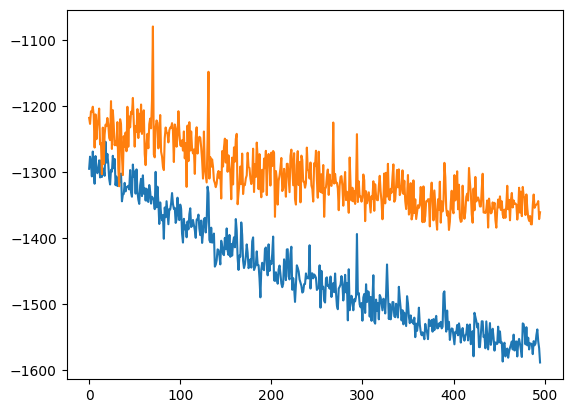

alpha 0.1 default_lr 0.0005


In [13]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [14]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [15]:
print(datetime.datetime.now())

2023-06-02 00:09:04.592393


# Iter2

In [16]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [17]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.67895  validloss 2.58996±0.00000  bestvalidloss 2.58996  last_update 0
train: iter 1  trainloss 1.22604  validloss 1.45498±0.00000  bestvalidloss 1.45498  last_update 0
train: iter 2  trainloss 1.06643  validloss 1.19412±0.00000  bestvalidloss 1.19412  last_update 0
train: iter 3  trainloss 0.96747  validloss 1.06688±0.00000  bestvalidloss 1.06688  last_update 0
train: iter 4  trainloss 0.92504  validloss 1.03087±0.00000  bestvalidloss 1.03087  last_update 0
train: iter 5  trainloss 0.88162  validloss 0.95662±0.00000  bestvalidloss 0.95662  last_update 0
train: iter 6  trainloss 0.85285  validloss 0.91688±0.00000  bestvalidloss 0.91688  last_update 0
train: iter 7  trainloss 0.82677  validloss 0.89455±0.00000  bestvalidloss 0.89455  last_update 0
train: iter 8  trainloss 0.80981  validloss 0.89023±0.00000  bestvalidloss 0.89023  last_update 0
train: iter 9  trainloss 0.79222  validloss 0.85889±0.00000  bestvalidloss 0.85889  last_update 0
train: iter 10  trai

train: iter 84  trainloss 0.61109  validloss 0.74920±0.00000  bestvalidloss 0.73881  last_update 14
train: iter 85  trainloss 0.60950  validloss 0.73895±0.00000  bestvalidloss 0.73881  last_update 15
train: iter 86  trainloss 0.60951  validloss 0.74638±0.00000  bestvalidloss 0.73881  last_update 16
train: iter 87  trainloss 0.60616  validloss 0.73757±0.00000  bestvalidloss 0.73757  last_update 0
train: iter 88  trainloss 0.60306  validloss 0.74383±0.00000  bestvalidloss 0.73757  last_update 1
train: iter 89  trainloss 0.60591  validloss 0.74636±0.00000  bestvalidloss 0.73757  last_update 2
train: iter 90  trainloss 0.60573  validloss 0.73088±0.00000  bestvalidloss 0.73088  last_update 0
train: iter 91  trainloss 0.60861  validloss 0.72919±0.00000  bestvalidloss 0.72919  last_update 0
train: iter 92  trainloss 0.60012  validloss 0.73366±0.00000  bestvalidloss 0.72919  last_update 1
train: iter 93  trainloss 0.60593  validloss 0.73559±0.00000  bestvalidloss 0.72919  last_update 2
train: 

train: iter 166  trainloss 0.56610  validloss 0.72922±0.00000  bestvalidloss 0.71344  last_update 52
train: iter 167  trainloss 0.57017  validloss 0.72636±0.00000  bestvalidloss 0.71344  last_update 53
train: iter 168  trainloss 0.56919  validloss 0.71884±0.00000  bestvalidloss 0.71344  last_update 54
train: iter 169  trainloss 0.56846  validloss 0.73411±0.00000  bestvalidloss 0.71344  last_update 55
train: iter 170  trainloss 0.56596  validloss 0.72615±0.00000  bestvalidloss 0.71344  last_update 56
train: iter 171  trainloss 0.56291  validloss 0.73386±0.00000  bestvalidloss 0.71344  last_update 57
train: iter 172  trainloss 0.56362  validloss 0.73653±0.00000  bestvalidloss 0.71344  last_update 58
train: iter 173  trainloss 0.56584  validloss 0.72703±0.00000  bestvalidloss 0.71344  last_update 59
train: iter 174  trainloss 0.56243  validloss 0.73328±0.00000  bestvalidloss 0.71344  last_update 60
train: iter 175  trainloss 0.56246  validloss 0.73023±0.00000  bestvalidloss 0.71344  last_

([1.6789539862424134,
  1.2260427217930556,
  1.0664316333830357,
  0.9674727009609342,
  0.9250376218929887,
  0.8816197471693158,
  0.8528521884232759,
  0.8267738275229931,
  0.8098099211230874,
  0.7922203879803419,
  0.7765841381624341,
  0.763228708319366,
  0.7517881959676742,
  0.7471954906359315,
  0.7409191761165858,
  0.7375221624970436,
  0.7263430554419756,
  0.7277602955698967,
  0.7195818433538079,
  0.715650025382638,
  0.7108669985085726,
  0.7013741105794906,
  0.7109025113284588,
  0.6968669462949038,
  0.6958075342699885,
  0.6937080852687358,
  0.6903483957052231,
  0.6881040304899215,
  0.6818600988015533,
  0.6797139631584287,
  0.6803555965423584,
  0.6770298294723034,
  0.6822932850569486,
  0.6687641272321343,
  0.6766095358878375,
  0.6698715448379516,
  0.6680902615189552,
  0.664275204949081,
  0.6613466823473573,
  0.6581406231969595,
  0.6591826414689421,
  0.6579330755397678,
  0.6568833701312542,
  0.6531773081049324,
  0.6508343636989593,
  0.649828117

In [18]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.158073395580052
valid_loss:  -8.255039835834502
weight_alpha 1.0 h_min_tilde -12.324072 ell_tilde -5.7774666836309425 kappa_tilde 0.00039083362828899813
train_loss:  -7.431704903411864
valid_loss:  -6.868102540588379
weight_alpha 0.1 h_min_tilde -12.324072 ell_tilde -7.318984430847167 kappa_tilde 0.00044698625114723665


In [19]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1481.34382  validloss -1378.51489±0.00000  bestvalidloss -1378.51489  last_update 0
train: iter 1  trainloss -1517.14739  validloss -1402.93839±0.00000  bestvalidloss -1402.93839  last_update 0
train: iter 2  trainloss -1499.01201  validloss -1412.09131±0.00000  bestvalidloss -1412.09131  last_update 0
train: iter 3  trainloss -1506.73862  validloss -1401.20991±0.00000  bestvalidloss -1412.09131  last_update 1
train: iter 4  trainloss -1503.27122  validloss -1388.52199±0.00000  bestvalidloss -1412.09131  last_update 2
train: iter 5  trainloss -1504.35136  validloss -1391.29008±0.00000  bestvalidloss -1412.09131  last_update 3
train: iter 6  trainloss -1478.43362  validloss -1400.02607±0.00000  bestvalidloss -1412.09131  last_update 4
train: iter 7  trainloss -1507.19784  validloss -1419.65451±0.00000  bestvalidloss -1419.65451  last_update 0
train: iter 8  trainloss -1518.54336  validloss -1398.38252±0.00000  bestva

train: iter 74  trainloss -1528.29367  validloss -1378.10761±0.00000  bestvalidloss -1447.59989  last_update 53
train: iter 75  trainloss -1518.70127  validloss -1359.44065±0.00000  bestvalidloss -1447.59989  last_update 54
train: iter 76  trainloss -1553.42629  validloss -1354.81582±0.00000  bestvalidloss -1447.59989  last_update 55
train: iter 77  trainloss -1562.24606  validloss -1408.41153±0.00000  bestvalidloss -1447.59989  last_update 56
train: iter 78  trainloss -1535.57106  validloss -1342.09916±0.00000  bestvalidloss -1447.59989  last_update 57
train: iter 79  trainloss -1523.02672  validloss -1343.82758±0.00000  bestvalidloss -1447.59989  last_update 58
train: iter 80  trainloss -1527.89609  validloss -1374.97934±0.00000  bestvalidloss -1447.59989  last_update 59
train: iter 81  trainloss -1532.31454  validloss -1351.91707±0.00000  bestvalidloss -1447.59989  last_update 60
train: iter 82  trainloss -1534.23485  validloss -1407.26611±0.00000  bestvalidloss -1447.59989  last_up

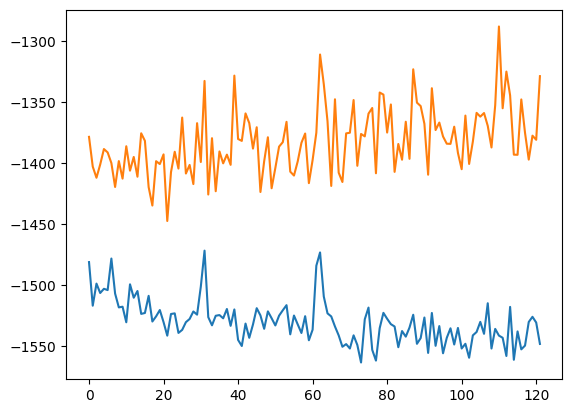

alpha 0.1 default_lr 0.0005


In [20]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [21]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [22]:
print(datetime.datetime.now())

2023-06-02 00:30:45.273533


Text(0, 0.5, 'loss')

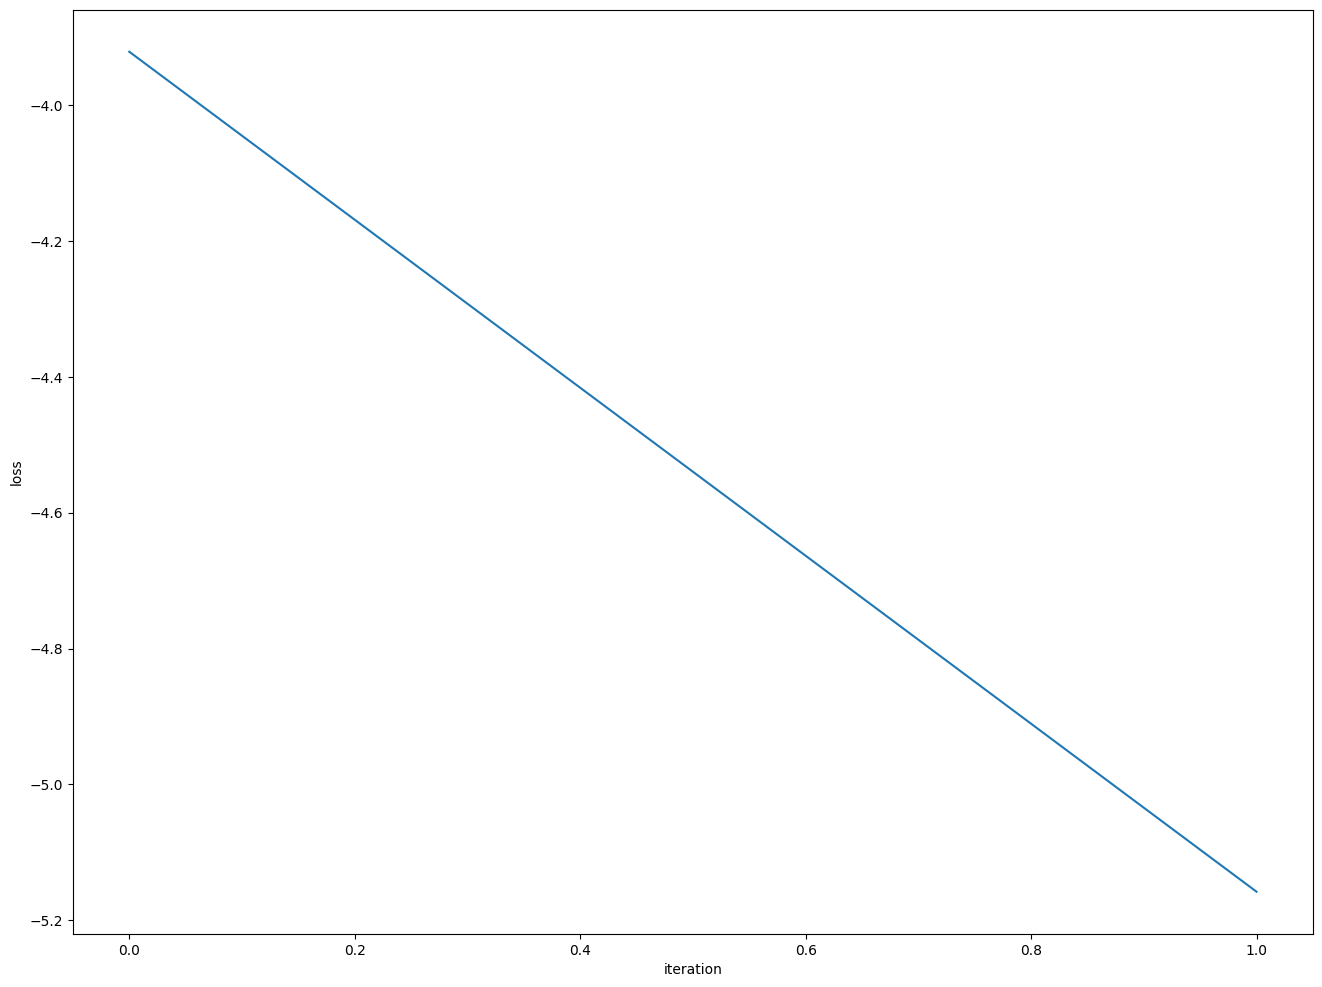

In [23]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


Text(0, 0.5, 'loss')

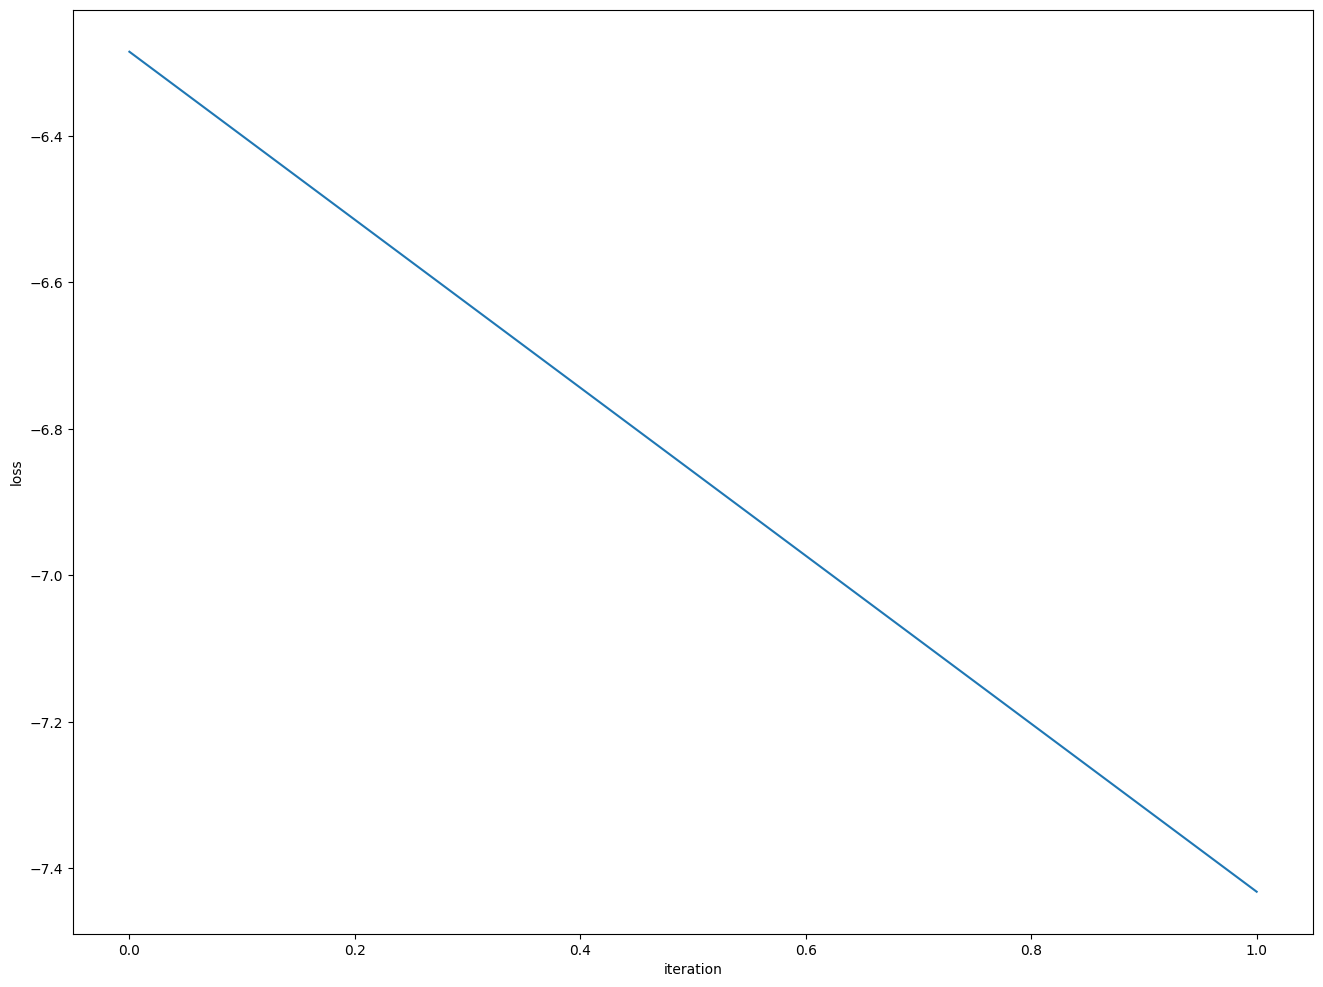

In [24]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


# Iter 3

In [25]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [26]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.71937  validloss 0.86536±0.00000  bestvalidloss 0.86536  last_update 0
train: iter 1  trainloss 0.68214  validloss 0.82864±0.00000  bestvalidloss 0.82864  last_update 0
train: iter 2  trainloss 0.66544  validloss 0.81142±0.00000  bestvalidloss 0.81142  last_update 0
train: iter 3  trainloss 0.66246  validloss 0.83314±0.00000  bestvalidloss 0.81142  last_update 1
train: iter 4  trainloss 0.65578  validloss 0.81787±0.00000  bestvalidloss 0.81142  last_update 2
train: iter 5  trainloss 0.65035  validloss 0.81417±0.00000  bestvalidloss 0.81142  last_update 3
train: iter 6  trainloss 0.64236  validloss 0.82166±0.00000  bestvalidloss 0.81142  last_update 4
train: iter 7  trainloss 0.64314  validloss 0.82093±0.00000  bestvalidloss 0.81142  last_update 5
train: iter 8  trainloss 0.63494  validloss 0.81161±0.00000  bestvalidloss 0.81142  last_update 6
train: iter 9  trainloss 0.63478  validloss 0.80586±0.00000  bestvalidloss 0.80586  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.57046  validloss 0.83507±0.00000  bestvalidloss 0.78042  last_update 41
train: iter 84  trainloss 0.56370  validloss 0.78522±0.00000  bestvalidloss 0.78042  last_update 42
train: iter 85  trainloss 0.56348  validloss 0.81876±0.00000  bestvalidloss 0.78042  last_update 43
train: iter 86  trainloss 0.57056  validloss 0.80530±0.00000  bestvalidloss 0.78042  last_update 44
train: iter 87  trainloss 0.56771  validloss 0.78809±0.00000  bestvalidloss 0.78042  last_update 45
train: iter 88  trainloss 0.56000  validloss 0.77937±0.00000  bestvalidloss 0.77937  last_update 0
train: iter 89  trainloss 0.56335  validloss 0.82275±0.00000  bestvalidloss 0.77937  last_update 1
train: iter 90  trainloss 0.57330  validloss 0.82318±0.00000  bestvalidloss 0.77937  last_update 2
train: iter 91  trainloss 0.56235  validloss 0.80064±0.00000  bestvalidloss 0.77937  last_update 3
train: iter 92  trainloss 0.56364  validloss 0.78988±0.00000  bestvalidloss 0.77937  last_update 4
train

train: iter 166  trainloss 0.53241  validloss 0.80818±0.00000  bestvalidloss 0.77610  last_update 53
train: iter 167  trainloss 0.53908  validloss 0.78955±0.00000  bestvalidloss 0.77610  last_update 54
train: iter 168  trainloss 0.53483  validloss 0.79937±0.00000  bestvalidloss 0.77610  last_update 55
train: iter 169  trainloss 0.52643  validloss 0.80774±0.00000  bestvalidloss 0.77610  last_update 56
train: iter 170  trainloss 0.53714  validloss 0.81686±0.00000  bestvalidloss 0.77610  last_update 57
train: iter 171  trainloss 0.53255  validloss 0.81322±0.00000  bestvalidloss 0.77610  last_update 58
train: iter 172  trainloss 0.53528  validloss 0.80221±0.00000  bestvalidloss 0.77610  last_update 59
train: iter 173  trainloss 0.53376  validloss 0.82274±0.00000  bestvalidloss 0.77610  last_update 60
train: iter 174  trainloss 0.52652  validloss 0.79154±0.00000  bestvalidloss 0.77610  last_update 61
train: iter 175  trainloss 0.53408  validloss 0.81414±0.00000  bestvalidloss 0.77610  last_

([0.7193726021796465,
  0.6821364391595125,
  0.6654394786804915,
  0.6624631740152835,
  0.6557752836495638,
  0.6503511555492878,
  0.6423596430569887,
  0.6431374533101917,
  0.6349435895681381,
  0.6347802044823766,
  0.6317540872842073,
  0.6296322192996741,
  0.6269590239971876,
  0.6237606780603528,
  0.6204151678830385,
  0.6197286810725927,
  0.6222072079777717,
  0.6187271505594254,
  0.6148231256753206,
  0.6122250592336058,
  0.6126134939491749,
  0.6112003359943629,
  0.6083200145512819,
  0.6167650317773223,
  0.6079333025962115,
  0.6127527676522732,
  0.6077247016131878,
  0.6056311363354325,
  0.6101738881319761,
  0.6013962004333735,
  0.608979820087552,
  0.6006376922130585,
  0.5979530345648527,
  0.6003995629027485,
  0.6001775372773409,
  0.6016689740121365,
  0.6027892546728253,
  0.5947943737730383,
  0.5924568528309464,
  0.5974380258470774,
  0.5906150065362453,
  0.5894341360777616,
  0.5949444528669119,
  0.5934863425791264,
  0.589478225633502,
  0.58783905

In [27]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.953076653105021
valid_loss:  -10.270194520521162
weight_alpha 1.0 h_min_tilde -12.3225355 ell_tilde -6.816500226588249 kappa_tilde 0.00042616767457026377
train_loss:  -7.478294953918457
valid_loss:  -6.865240572357178
weight_alpha 0.1 h_min_tilde -12.3225355 ell_tilde -7.355684077606202 kappa_tilde 0.00044870345641294206


In [28]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1499.22143  validloss -1378.34158±0.00000  bestvalidloss -1378.34158  last_update 0
train: iter 1  trainloss -1492.56029  validloss -1336.08650±0.00000  bestvalidloss -1378.34158  last_update 1
train: iter 2  trainloss -1490.31089  validloss -1320.85818±0.00000  bestvalidloss -1378.34158  last_update 2
train: iter 3  trainloss -1490.66657  validloss -1373.61987±0.00000  bestvalidloss -1378.34158  last_update 3
train: iter 4  trainloss -1525.03532  validloss -1371.52039±0.00000  bestvalidloss -1378.34158  last_update 4
train: iter 5  trainloss -1514.17776  validloss -1384.41227±0.00000  bestvalidloss -1384.41227  last_update 0
train: iter 6  trainloss -1514.18444  validloss -1384.82242±0.00000  bestvalidloss -1384.82242  last_update 0
train: iter 7  trainloss -1520.22845  validloss -1358.68871±0.00000  bestvalidloss -1384.82242  last_update 1
train: iter 8  trainloss -1497.38749  validloss -1390.05475±0.00000  bestva

train: iter 74  trainloss -1522.32991  validloss -1366.43686±0.00000  bestvalidloss -1408.99556  last_update 40
train: iter 75  trainloss -1497.88763  validloss -1359.40043±0.00000  bestvalidloss -1408.99556  last_update 41
train: iter 76  trainloss -1493.63773  validloss -1317.42186±0.00000  bestvalidloss -1408.99556  last_update 42
train: iter 77  trainloss -1472.53623  validloss -1315.96223±0.00000  bestvalidloss -1408.99556  last_update 43
train: iter 78  trainloss -1507.04012  validloss -1323.40737±0.00000  bestvalidloss -1408.99556  last_update 44
train: iter 79  trainloss -1513.89713  validloss -1357.21504±0.00000  bestvalidloss -1408.99556  last_update 45
train: iter 80  trainloss -1529.93143  validloss -1320.56542±0.00000  bestvalidloss -1408.99556  last_update 46
train: iter 81  trainloss -1503.98725  validloss -1289.30045±0.00000  bestvalidloss -1408.99556  last_update 47
train: iter 82  trainloss -1526.83462  validloss -1328.76610±0.00000  bestvalidloss -1408.99556  last_up

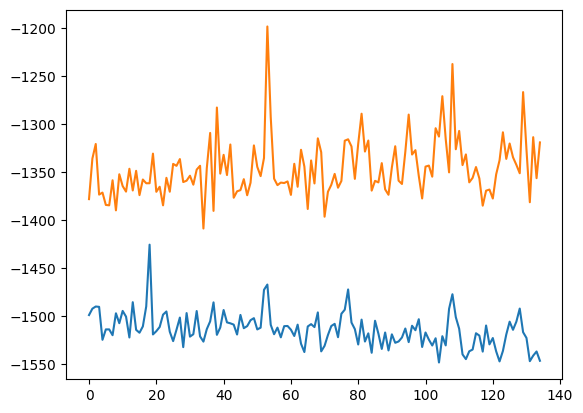

alpha 0.1 default_lr 0.0005


In [29]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [30]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [31]:
print(datetime.datetime.now())

2023-06-02 00:51:16.849143


# 評価関数計算

In [32]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [33]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.68627  validloss 0.80728±0.00000  bestvalidloss 0.80728  last_update 0
train: iter 1  trainloss 0.65088  validloss 0.79392±0.00000  bestvalidloss 0.79392  last_update 0
train: iter 2  trainloss 0.64233  validloss 0.79826±0.00000  bestvalidloss 0.79392  last_update 1
train: iter 3  trainloss 0.63393  validloss 0.79619±0.00000  bestvalidloss 0.79392  last_update 2
train: iter 4  trainloss 0.62925  validloss 0.78367±0.00000  bestvalidloss 0.78367  last_update 0
train: iter 5  trainloss 0.62236  validloss 0.80271±0.00000  bestvalidloss 0.78367  last_update 1
train: iter 6  trainloss 0.61815  validloss 0.79119±0.00000  bestvalidloss 0.78367  last_update 2
train: iter 7  trainloss 0.61695  validloss 0.78511±0.00000  bestvalidloss 0.78367  last_update 3
train: iter 8  trainloss 0.61990  validloss 0.79527±0.00000  bestvalidloss 0.78367  last_update 4
train: iter 9  trainloss 0.61243  validloss 0.78786±0.00000  bestvalidloss 0.78367  last_update 5
train: iter 10  trai

train: iter 83  trainloss 0.55471  validloss 0.77920±0.00000  bestvalidloss 0.75990  last_update 14
train: iter 84  trainloss 0.54978  validloss 0.76898±0.00000  bestvalidloss 0.75990  last_update 15
train: iter 85  trainloss 0.55069  validloss 0.77949±0.00000  bestvalidloss 0.75990  last_update 16
train: iter 86  trainloss 0.55164  validloss 0.77014±0.00000  bestvalidloss 0.75990  last_update 17
train: iter 87  trainloss 0.54981  validloss 0.77219±0.00000  bestvalidloss 0.75990  last_update 18
train: iter 88  trainloss 0.55284  validloss 0.77845±0.00000  bestvalidloss 0.75990  last_update 19
train: iter 89  trainloss 0.55224  validloss 0.77516±0.00000  bestvalidloss 0.75990  last_update 20
train: iter 90  trainloss 0.55497  validloss 0.76537±0.00000  bestvalidloss 0.75990  last_update 21
train: iter 91  trainloss 0.55078  validloss 0.75947±0.00000  bestvalidloss 0.75947  last_update 0
train: iter 92  trainloss 0.55006  validloss 0.77402±0.00000  bestvalidloss 0.75947  last_update 1
tr

train: iter 165  trainloss 0.52832  validloss 0.77548±0.00000  bestvalidloss 0.75658  last_update 27
train: iter 166  trainloss 0.52867  validloss 0.77308±0.00000  bestvalidloss 0.75658  last_update 28
train: iter 167  trainloss 0.52925  validloss 0.78322±0.00000  bestvalidloss 0.75658  last_update 29
train: iter 168  trainloss 0.52466  validloss 0.76956±0.00000  bestvalidloss 0.75658  last_update 30
train: iter 169  trainloss 0.52651  validloss 0.78453±0.00000  bestvalidloss 0.75658  last_update 31
train: iter 170  trainloss 0.52475  validloss 0.77427±0.00000  bestvalidloss 0.75658  last_update 32
train: iter 171  trainloss 0.52389  validloss 0.79765±0.00000  bestvalidloss 0.75658  last_update 33
train: iter 172  trainloss 0.52692  validloss 0.78235±0.00000  bestvalidloss 0.75658  last_update 34
train: iter 173  trainloss 0.53296  validloss 0.77546±0.00000  bestvalidloss 0.75658  last_update 35
train: iter 174  trainloss 0.54322  validloss 0.83808±0.00000  bestvalidloss 0.75658  last_

([0.686266172491014,
  0.6508776161819696,
  0.6423279972746968,
  0.6339281912893057,
  0.6292467676103115,
  0.6223643988370895,
  0.6181531442329288,
  0.6169500147923828,
  0.6198958285152912,
  0.6124341627582908,
  0.613074480369687,
  0.604800209030509,
  0.6003858905285597,
  0.6031533971428871,
  0.6012306047603488,
  0.603980471752584,
  0.59820994772017,
  0.5976086085662246,
  0.5952194664627314,
  0.5983775018714368,
  0.5914510590955615,
  0.5893531191162765,
  0.5899400829337538,
  0.592267333343625,
  0.5900746298953891,
  0.5940731950104237,
  0.5887742293998599,
  0.583423204999417,
  0.5840009701438248,
  0.5853546164929867,
  0.5856962849386036,
  0.5785679942928255,
  0.5762958673760294,
  0.5803420784883201,
  0.5914255373179913,
  0.5829814462922513,
  0.5794134233146906,
  0.5746430810540915,
  0.5758735574781895,
  0.576426206342876,
  0.5717456778511405,
  0.5778428904712201,
  0.5799171588383615,
  0.5756258152425289,
  0.5749334124848247,
  0.573725227359682

In [34]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.818807494175434
valid_loss:  -10.326208654403686
weight_alpha 1.0 h_min_tilde -12.323955 ell_tilde -5.920287726221085 kappa_tilde 0.00039517151771226297
train_loss:  -7.126923121643067
valid_loss:  -6.504446925354005
weight_alpha 0.1 h_min_tilde -12.323955 ell_tilde -7.002427882385255 kappa_tilde 0.0004334927887195306


In [35]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 54.92943  validloss 61.71203±0.00000  bestvalidloss 61.71203  last_update 0
train: iter 1  trainloss 39.93498  validloss 44.89459±0.00000  bestvalidloss 44.89459  last_update 0
train: iter 2  trainloss 29.36880  validloss 35.00303±0.00000  bestvalidloss 35.00303  last_update 0
train: iter 3  trainloss 21.70382  validloss 23.76209±0.00000  bestvalidloss 23.76209  last_update 0
train: iter 4  trainloss 16.02253  validloss 17.83173±0.00000  bestvalidloss 17.83173  last_update 0
train: iter 5  trainloss 11.49092  validloss 12.88424±0.00000  bestvalidloss 12.88424  last_update 0
train: iter 6  trainloss 8.01599  validloss 9.21415±0.00000  bestvalidloss 9.21415  last_update 0
train: iter 7  trainloss 5.97482  validloss 6.87266±0.00000  bestvalidloss 6.87266  last_update 0
train: iter 8  trainloss 3.88768  validloss 4.23055±0.00000  bestvalidloss 4.23055  last_update 0
train: iter 9  trainloss 2.44231  validloss 2.50649±0.00000  bestvalidloss 2.50649  last_update 0
tr

train: iter 87  trainloss -1.06490  validloss -1.45527±0.00000  bestvalidloss -1.57622  last_update 17
train: iter 88  trainloss -1.06884  validloss -1.57934±0.00000  bestvalidloss -1.57934  last_update 0
train: iter 89  trainloss -0.98341  validloss -1.51448±0.00000  bestvalidloss -1.57934  last_update 1
train: iter 90  trainloss -0.99097  validloss -1.51047±0.00000  bestvalidloss -1.57934  last_update 2
train: iter 91  trainloss -1.04131  validloss -1.49494±0.00000  bestvalidloss -1.57934  last_update 3
train: iter 92  trainloss -1.06781  validloss -1.52798±0.00000  bestvalidloss -1.57934  last_update 4
train: iter 93  trainloss -1.06246  validloss -1.48124±0.00000  bestvalidloss -1.57934  last_update 5
train: iter 94  trainloss -1.03975  validloss -1.45406±0.00000  bestvalidloss -1.57934  last_update 6
train: iter 95  trainloss -1.01806  validloss -1.56863±0.00000  bestvalidloss -1.57934  last_update 7
train: iter 96  trainloss -1.06648  validloss -1.44525±0.00000  bestvalidloss -1.

train: iter 180  trainloss -1.02366  validloss -1.55351±0.00000  bestvalidloss -1.63730  last_update 12
train: iter 181  trainloss -0.94020  validloss -1.56199±0.00000  bestvalidloss -1.63730  last_update 13
train: iter 182  trainloss -1.05912  validloss -1.50866±0.00000  bestvalidloss -1.63730  last_update 14
train: iter 183  trainloss -1.05813  validloss -1.43891±0.00000  bestvalidloss -1.63730  last_update 15
train: iter 184  trainloss -1.03376  validloss -1.55093±0.00000  bestvalidloss -1.63730  last_update 16
train: iter 185  trainloss -1.02250  validloss -1.44975±0.00000  bestvalidloss -1.63730  last_update 17
train: iter 186  trainloss -1.03093  validloss -1.50812±0.00000  bestvalidloss -1.63730  last_update 18
train: iter 187  trainloss -0.99602  validloss -1.52691±0.00000  bestvalidloss -1.63730  last_update 19
train: iter 188  trainloss -1.03063  validloss -1.50335±0.00000  bestvalidloss -1.63730  last_update 20
train: iter 189  trainloss -1.01839  validloss -1.58589±0.00000 

train: iter 272  trainloss -1.05251  validloss -1.53081±0.00000  bestvalidloss -1.66077  last_update 11
train: iter 273  trainloss -1.07732  validloss -1.55948±0.00000  bestvalidloss -1.66077  last_update 12
train: iter 274  trainloss -1.02605  validloss -1.47000±0.00000  bestvalidloss -1.66077  last_update 13
train: iter 275  trainloss -1.01760  validloss -1.43808±0.00000  bestvalidloss -1.66077  last_update 14
train: iter 276  trainloss -0.98742  validloss -1.47666±0.00000  bestvalidloss -1.66077  last_update 15
train: iter 277  trainloss -1.05539  validloss -1.53295±0.00000  bestvalidloss -1.66077  last_update 16
train: iter 278  trainloss -1.05424  validloss -1.57826±0.00000  bestvalidloss -1.66077  last_update 17
train: iter 279  trainloss -0.99027  validloss -1.48385±0.00000  bestvalidloss -1.66077  last_update 18
train: iter 280  trainloss -1.03705  validloss -1.55684±0.00000  bestvalidloss -1.66077  last_update 19
train: iter 281  trainloss -1.04903  validloss -1.46360±0.00000 

train: iter 365  trainloss -1.04846  validloss -1.52267±0.00000  bestvalidloss -1.66511  last_update 67
train: iter 366  trainloss -1.02419  validloss -1.49963±0.00000  bestvalidloss -1.66511  last_update 68
train: iter 367  trainloss -1.04183  validloss -1.54369±0.00000  bestvalidloss -1.66511  last_update 69
train: iter 368  trainloss -1.07601  validloss -1.50061±0.00000  bestvalidloss -1.66511  last_update 70
train: iter 369  trainloss -1.06938  validloss -1.52876±0.00000  bestvalidloss -1.66511  last_update 71
train: iter 370  trainloss -1.07247  validloss -1.56689±0.00000  bestvalidloss -1.66511  last_update 72
train: iter 371  trainloss -1.01055  validloss -1.44891±0.00000  bestvalidloss -1.66511  last_update 73
train: iter 372  trainloss -1.04946  validloss -1.53783±0.00000  bestvalidloss -1.66511  last_update 74
train: iter 373  trainloss -1.02559  validloss -1.48592±0.00000  bestvalidloss -1.66511  last_update 75
train: iter 374  trainloss -1.04578  validloss -1.51027±0.00000 

In [36]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-0.1393, -1.7206, -2.4540, -5.2936], requires_grad=True)


In [37]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 1.91110  validloss 29.58818±0.00000  bestvalidloss 29.58818  last_update 0
train: iter 1  trainloss 1.66327  validloss 28.19712±0.00000  bestvalidloss 28.19712  last_update 0
train: iter 2  trainloss 1.56426  validloss 32.78719±0.00000  bestvalidloss 28.19712  last_update 1
train: iter 3  trainloss 1.66490  validloss 28.62381±0.00000  bestvalidloss 28.19712  last_update 2
train: iter 4  trainloss 1.67175  validloss 30.61407±0.00000  bestvalidloss 28.19712  last_update 3
train: iter 5  trainloss 1.57937  validloss 29.03596±0.00000  bestvalidloss 28.19712  last_update 4
train: iter 6  trainloss 1.60156  validloss 29.53571±0.00000  bestvalidloss 28.19712  last_update 5
train: iter 7  trainloss 1.52178  validloss 30.11034±0.00000  bestvalidloss 28.19712  last_update 6
train: iter 8  trainloss 1.69612  validloss 29.06931±0.00000  bestvalidloss 28.19712  last_update 7
train: iter 9  trainloss 1.52554  validloss 30.79596±0.00000  bestvalidloss 28.19712  last_update 8


train: iter 81  trainloss 1.57557  validloss 29.73909±0.00000  bestvalidloss 27.47332  last_update 42
train: iter 82  trainloss 1.62126  validloss 31.58392±0.00000  bestvalidloss 27.47332  last_update 43
train: iter 83  trainloss 1.62477  validloss 29.41043±0.00000  bestvalidloss 27.47332  last_update 44
train: iter 84  trainloss 1.56480  validloss 29.90680±0.00000  bestvalidloss 27.47332  last_update 45
train: iter 85  trainloss 1.47233  validloss 32.52460±0.00000  bestvalidloss 27.47332  last_update 46
train: iter 86  trainloss 1.59624  validloss 29.34537±0.00000  bestvalidloss 27.47332  last_update 47
train: iter 87  trainloss 1.53434  validloss 28.51569±0.00000  bestvalidloss 27.47332  last_update 48
train: iter 88  trainloss 1.59389  validloss 28.01867±0.00000  bestvalidloss 27.47332  last_update 49
train: iter 89  trainloss 1.60734  validloss 28.19076±0.00000  bestvalidloss 27.47332  last_update 50
train: iter 90  trainloss 1.55821  validloss 29.18219±0.00000  bestvalidloss 27.47

train: iter 161  trainloss 1.54569  validloss 28.99979±0.00000  bestvalidloss 27.11789  last_update 30
train: iter 162  trainloss 1.55299  validloss 30.06415±0.00000  bestvalidloss 27.11789  last_update 31
train: iter 163  trainloss 1.61315  validloss 32.71424±0.00000  bestvalidloss 27.11789  last_update 32
train: iter 164  trainloss 1.67875  validloss 29.77843±0.00000  bestvalidloss 27.11789  last_update 33
train: iter 165  trainloss 1.66703  validloss 29.26913±0.00000  bestvalidloss 27.11789  last_update 34
train: iter 166  trainloss 1.59204  validloss 29.57984±0.00000  bestvalidloss 27.11789  last_update 35
train: iter 167  trainloss 1.60392  validloss 30.15474±0.00000  bestvalidloss 27.11789  last_update 36
train: iter 168  trainloss 1.54867  validloss 28.37045±0.00000  bestvalidloss 27.11789  last_update 37
train: iter 169  trainloss 1.60850  validloss 30.24420±0.00000  bestvalidloss 27.11789  last_update 38
train: iter 170  trainloss 1.68740  validloss 30.14253±0.00000  bestvalid

train: iter 241  trainloss 1.58656  validloss 30.08911±0.00000  bestvalidloss 27.08185  last_update 20
train: iter 242  trainloss 1.58917  validloss 29.87471±0.00000  bestvalidloss 27.08185  last_update 21
train: iter 243  trainloss 1.55757  validloss 29.98154±0.00000  bestvalidloss 27.08185  last_update 22
train: iter 244  trainloss 1.49342  validloss 31.48888±0.00000  bestvalidloss 27.08185  last_update 23
train: iter 245  trainloss 1.55202  validloss 29.49328±0.00000  bestvalidloss 27.08185  last_update 24
train: iter 246  trainloss 1.54659  validloss 30.29385±0.00000  bestvalidloss 27.08185  last_update 25
train: iter 247  trainloss 1.62026  validloss 32.47448±0.00000  bestvalidloss 27.08185  last_update 26
train: iter 248  trainloss 1.46472  validloss 29.74488±0.00000  bestvalidloss 27.08185  last_update 27
train: iter 249  trainloss 1.51684  validloss 28.23041±0.00000  bestvalidloss 27.08185  last_update 28
train: iter 250  trainloss 1.64003  validloss 28.43529±0.00000  bestvalid

In [38]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-9.6075)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(7.1011)


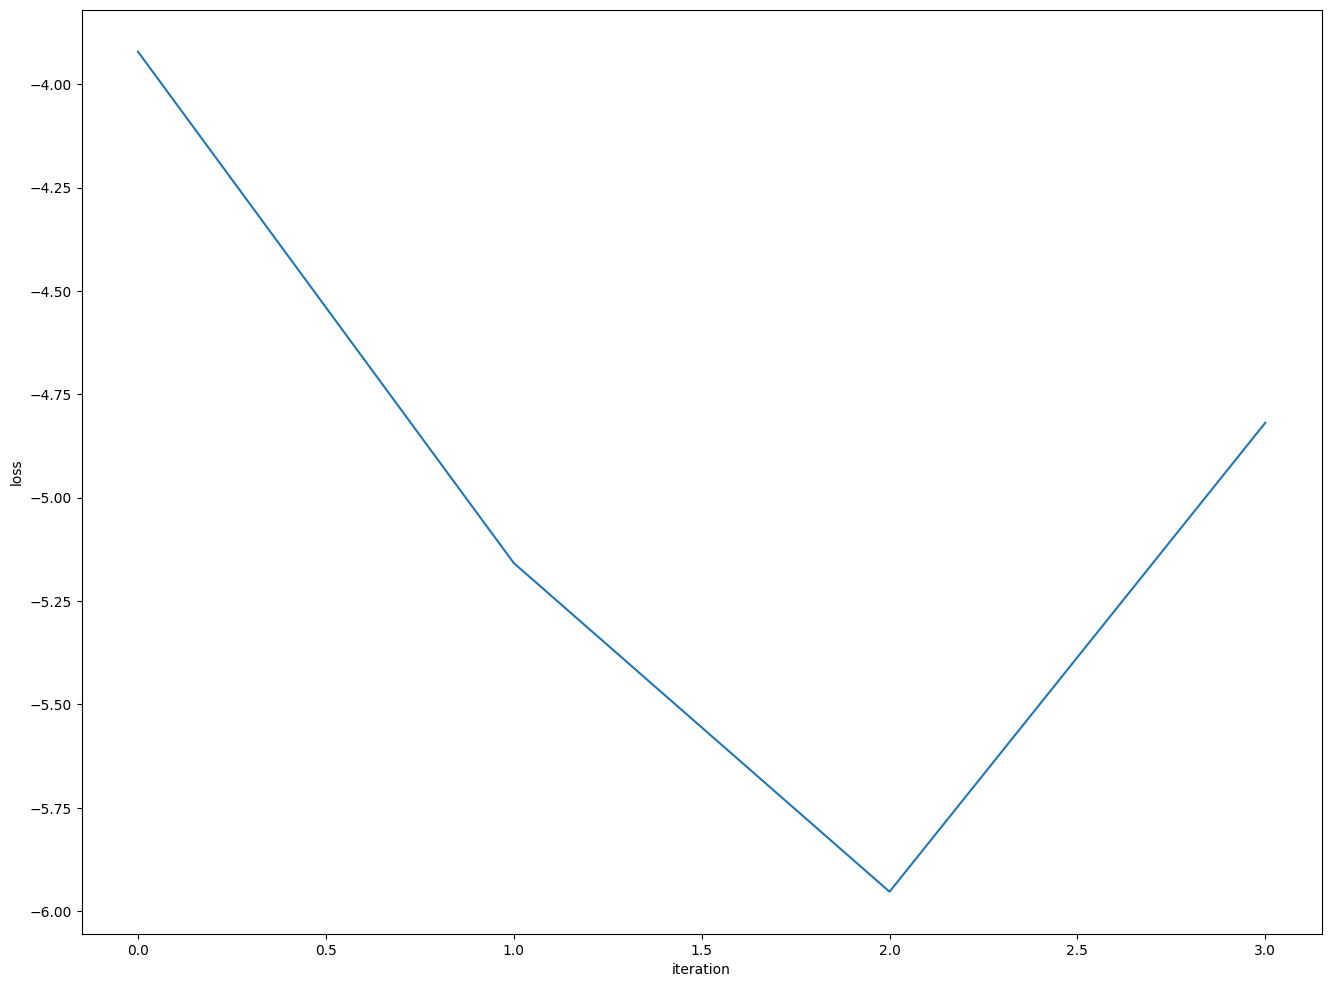

In [39]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

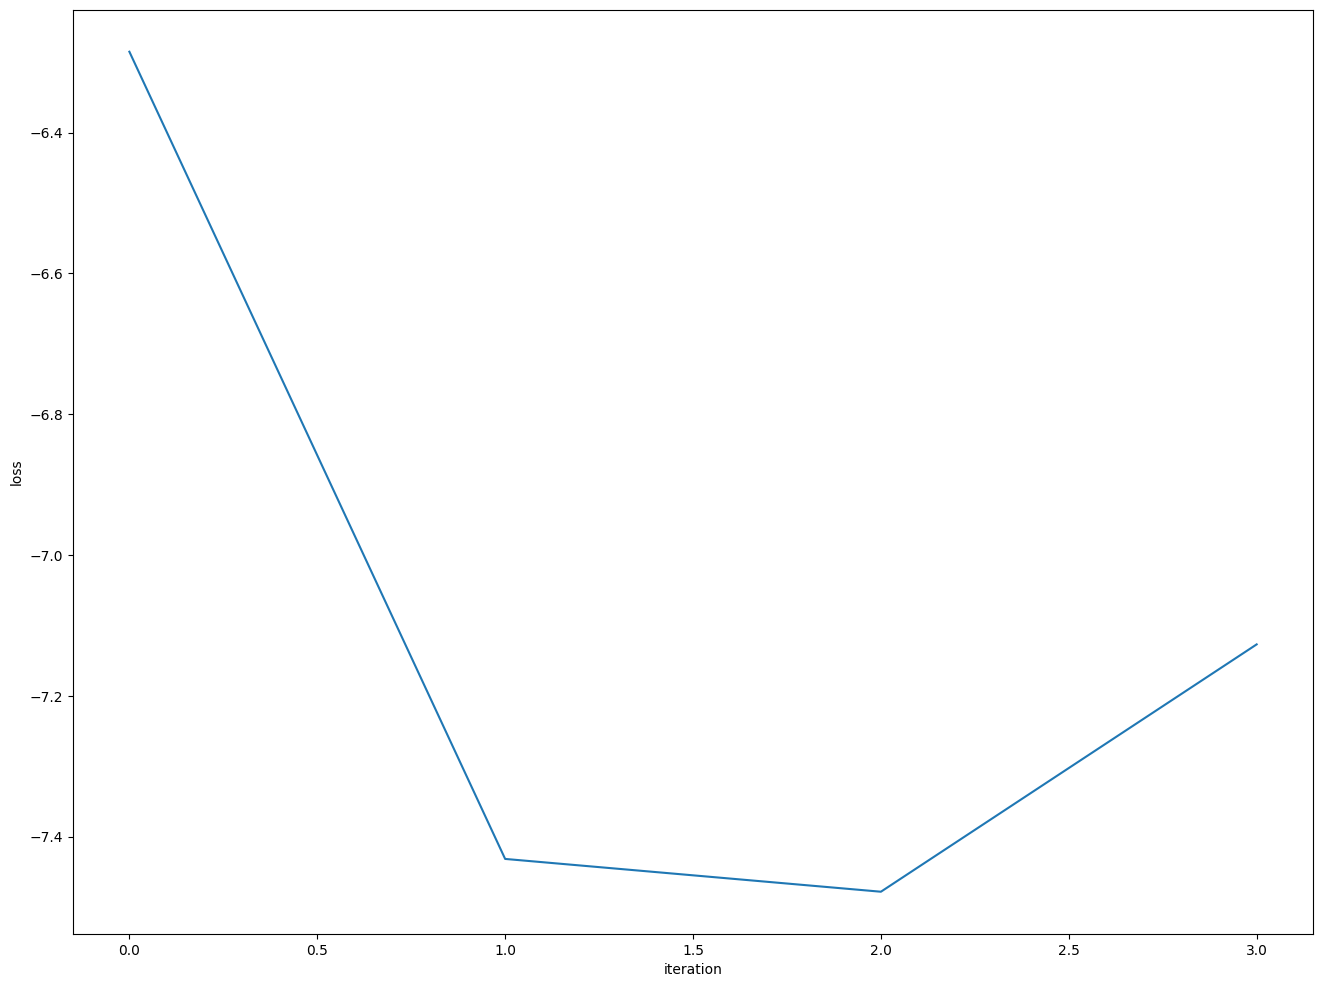

In [40]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")